## INF367 Mandatory Assignment 2

<p style="text-align:right;"><b>Written by:</b> Tobias Husebø, Lasse Holt, Martin Flo Øfstaas</p>
    <p style="text-align:right;"><i>Due: 8th of November 2024, (12:00)</i></p>

NB! look in notebook for more in-detail report

---

### Imports

We start of by declaring all imports used in the assignment.


In [1]:
# SKLEARN:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

# QISKIT:
from qiskit import QuantumCircuit, transpile, assemble, ClassicalRegister
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit import ParameterVector

# PANDAS:
import pandas as pd

# NUMPY:
import numpy as np

# MATPLOTLIB:
import matplotlib.pyplot as plt

# COPY
import copy as c

# RANDOM
import random as r

# TIME
import time as t

# SEABORN
import seaborn as sns

---

&nbsp;

### Data initialization:

We start of by initializing our dataset. We do this via sklearns `load_iris()`. Furthermore we wish to explore the entirety of the dataset and not only the training subset. There is a few reasons for this. Firstly, the dataset is already relatively small. This means that splitting it via `train_test_split()` may not provide a represenative view of its characteristics. Thus, data exploration on the training subset may yield skewed pictures of what the data actually looks like. Secondly, the iris dataset is well-known and most of us has already worked with it, meaning concerns about data leakage are minimal.

In [2]:
# Loading the dataset:
data = load_iris()
X = data.data
y = data.target

---

&nbsp;

### Data Exploration:

In our data exploration step, we start of by looking at some fundamental properties of the dataset. Namely, missing values, label distribution and more. This leads to valuable insight which in return may help us choose a preformance metric, which encoding to utilize and etc.

We start of by defining some functions for the data exploration:

In [3]:
features = data.feature_names
labels = data.target_names
num_datapoints = len(X)
num_dims = len(features)


# Print the counts of datapoints, dims and alike
def dataset_counts(X, y):
    out_string = f"\nThe dataset contains {num_datapoints} datapoints"
    out_string += f"\nThe dataset contains {len(features)} dimensions\n\n"
    
    for i in range(len(features)):
        out_string += f"Feature {i+1}: {features[i]}\n"
        out_string += f"Feature {i+1} value interval [{np.min(X[:,i])}, {np.max(X[:,i])}]\n\n"
    
    print(out_string)
    

# Print out missing values (if any)
def missing_values_dataset(X, y):
    missing_X = np.isnan(X).any()
    missing_y = np.isnan(y).any()
    
    if missing_X or missing_y:
        print("The dataset contains one or more missing values.")
    else:
        print("The dataset is complete.")
        
        
# Visualize label distribution
def feature_count_distribution(X):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()  # Flatten the axes array for easy indexing

    # Plot each feature in a separate subplot
    for i in range(len(features)):
        axes[i].hist(X[:, i], bins=20, color='blue', alpha=0.7)
        axes[i].set_title(f'{features[i]} distribution')
        axes[i].set_xlabel('Value')
        axes[i].grid(axis="y")
        axes[i].set_ylabel('Frequency')
        
    fig.suptitle('Fig 1 - Distribution of Each Feature in Iris Dataset', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    
# Visualize label distribution
def label_distribution(y):
    _, counts = np.unique(y, return_counts=True)
    ticks = [label for label in labels]
    colors = plt.cm.tab10.colors[:len(counts)] 
    
    
    plt.bar(np.arange(len(counts)), counts, tick_label=ticks, color=colors)
    plt.xlabel('Each distinct label')
    plt.ylabel('Label count')
    plt.grid(axis="y")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.title('Fig 2 - Distribution of Labels', fontsize=14, fontweight="bold")
    plt.show()

&nbsp;

After defining some functions we can utilize them to gain valuable insight:

In [4]:
dataset_counts(X, y)


The dataset contains 150 datapoints
The dataset contains 4 dimensions

Feature 1: sepal length (cm)
Feature 1 value interval [4.3, 7.9]

Feature 2: sepal width (cm)
Feature 2 value interval [2.0, 4.4]

Feature 3: petal length (cm)
Feature 3 value interval [1.0, 6.9]

Feature 4: petal width (cm)
Feature 4 value interval [0.1, 2.5]




In [5]:
missing_values_dataset(X, y)

The dataset is complete.


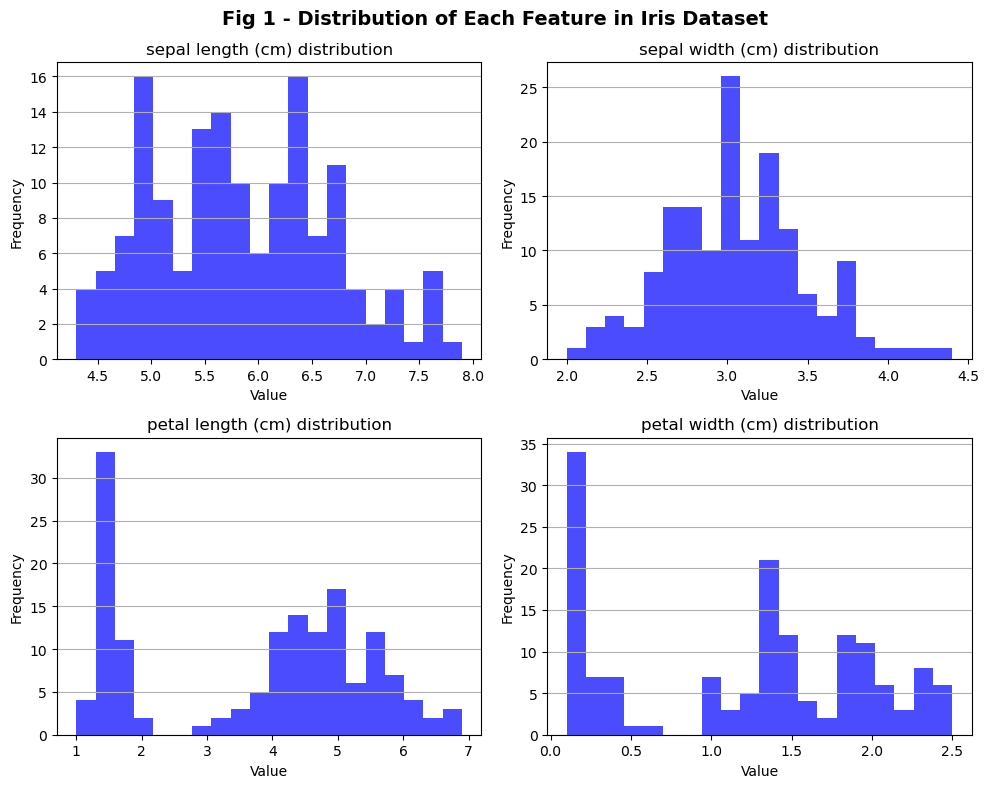

In [6]:
feature_count_distribution(X)

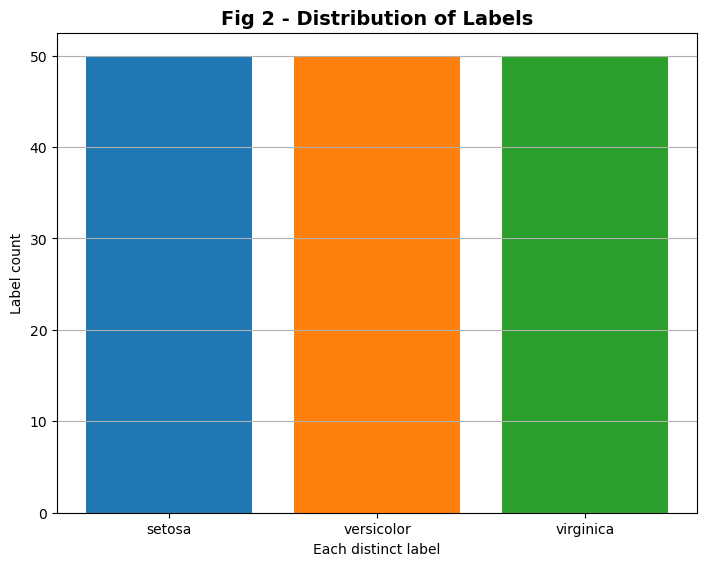

In [7]:
label_distribution(y)    

&nbsp;

After running our exploration functions we have gained some insight which will help us further on in the preprocessing / encoding step.

---

&nbsp;

### Data Preprocessing / Encoding:

#### PCA - Principal Component Analysis:

In our preprocessing stage we start of by visualizing the cumulative explained variance of each principal component, via the function `PCA_on_dataset(X):`

In [8]:
# Function for visualizing the cumulative information
# conveyed by each PC in after PCA on the dataset
def PCA_on_dataset(X):
    # Initializing PCA object with seed for reproducibility:
    seed = 55
    pca = PCA(random_state=seed)
    pca.fit(X)
    
    # Visualize the cumulative variance:
    svs = pca.singular_values_
    expl_variance = pca.explained_variance_ratio_
    
    plt.plot(np.arange(1, len(svs)+1, 1), [sum(expl_variance[:i+1])*100 for i in range(len(expl_variance))])
    plt.yticks(np.arange(80, 101, 1))
    plt.xticks(np.arange(1,len(svs)+0.1, 1))
    plt.ylim(78, 102)
    plt.xlabel("Number of PCs")
    plt.ylabel("Cumulative explained variance (%)")
    plt.title('Fig 3 - PCA on Dataset', fontsize=14, fontweight="bold")
    plt.grid()
    
    plt.show()
    

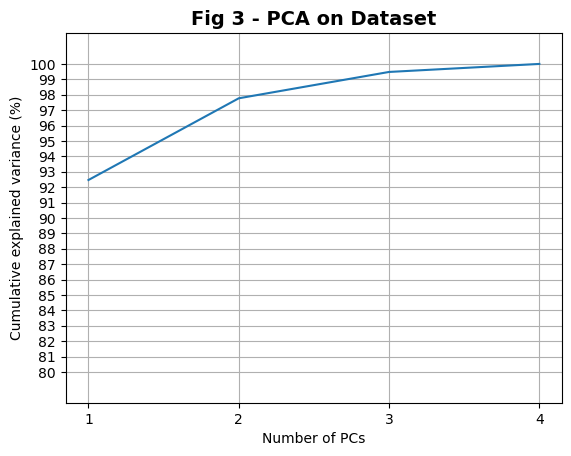

In [9]:
PCA_on_dataset(X)

Via looking at this it is clear that by utilizing only 2 of our 4 principal components we are able to capture `98%` of the information in the original dataset. Thus, we can simply project our datapoints on the axes´ formed by the first and second principal component to reduce the dimensionality and maintain almost all information in the dataset.

Thus, we reduce the dimensionality from 4 to 2 via `dim_reduction(X, num_PCs)`. Additionally, we can plot the data with `scatter_plot_2d_data(X, y)` to visualize that the first 2 PC´s capture most of the information:

In [10]:
# Dimensionality reduce the set dataset to the given number
# of Principal Components:
def dim_reduction(X, num_PCs):
    # Initializing PCA object with seed for reproducibility:
    seed = 55
    pca = PCA(random_state=seed, n_components=2)
    
    # Return the dimensionality reduced dataset 
    return pca.fit_transform(X)

X_pca = dim_reduction(X, 2)

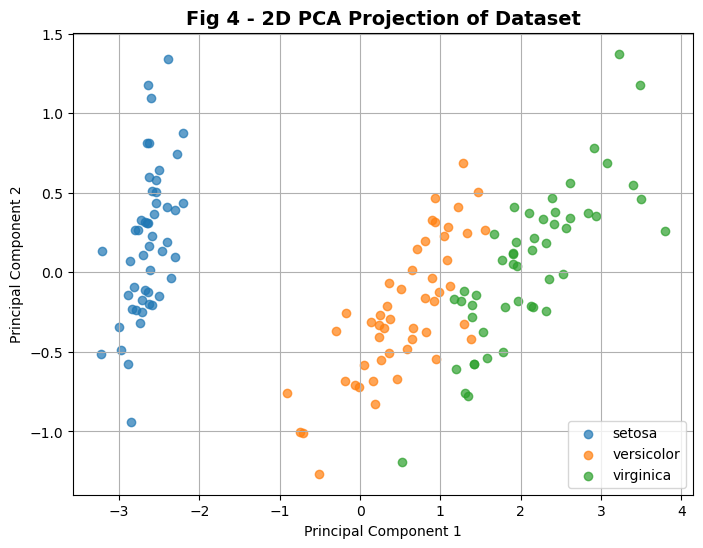

In [11]:
# Function for visualizing the reduced data using 2d scatter plot
def scatter_plot_2d_data(X, y, xlabel, ylabel, title, radian_ticks):
    # Define colors for each class
    colors = plt.cm.tab10.colors[:len(labels)] 
    labels_nr = [0, 1, 2]
    
    plt.figure(figsize=(8, 6))
    
    # Plot each class with a different color
    for i, label in enumerate(labels_nr):
        plt.scatter(X[y == label, 0], X[y == label, 1], 
                    color=colors[i], label=f'{labels[i]}', alpha=0.7)
    
    # If radian ticks is true, use radian ticks instead of regular
    if radian_ticks == True:
        ticks = np.linspace(0, np.pi, 5)  # Adjust the number of ticks as needed
        tick_labels = [f"{i:.2f}π" for i in np.linspace(0, 1, 5)]  # Labels like "0π", "0.5π", "1.0π", etc.

        plt.xticks(ticks, tick_labels)
        plt.yticks(ticks, tick_labels)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid()
    plt.show()

scatter_plot_2d_data(X_pca, y, "Principal Component 1", "Principal Component 2", "Fig 4 - 2D PCA Projection of Dataset", False)

&nbsp;

Now we have reduced the dimensionality of our datavector X, and furthermore plotted it. We can see from our plot that via applying PCA we have still retained most of the information in the original dataset as there appears clear clusters for each class.

---

&nbsp;

#### Scaling / Encoding:

In our implementation of the QNN we have concluded that angle encoding is the way to go for the dataset at hand. For further information on our choice look at the report. This means that we have to scale it on a scale from $ x \in [0, \pi]$ or $ x \in [0, 2\pi)$. This is because when utilizing angle encoding we cannot distinguish between for example: 

$$\forall c \in \mathbb{R}, \hspace{1em} a = c,  \hspace{1em} b = c + 2\pi \hspace{1em} \Rightarrow \hspace{1em} a \equiv b$$

By this we have chosen to scale from $[0, \pi]$ as we want the minimum and maximum values of the feature dataset to have the largest possible rotation from eachother. If we would have chosen, lets say $[0, 2\pi)$, min and max values would be extremely close to eachother. Thus, we scale via sklearns `MinMaxScaler()` function. We also want to plot the data to see that we still have maintained the original "structure" of the dataset: 

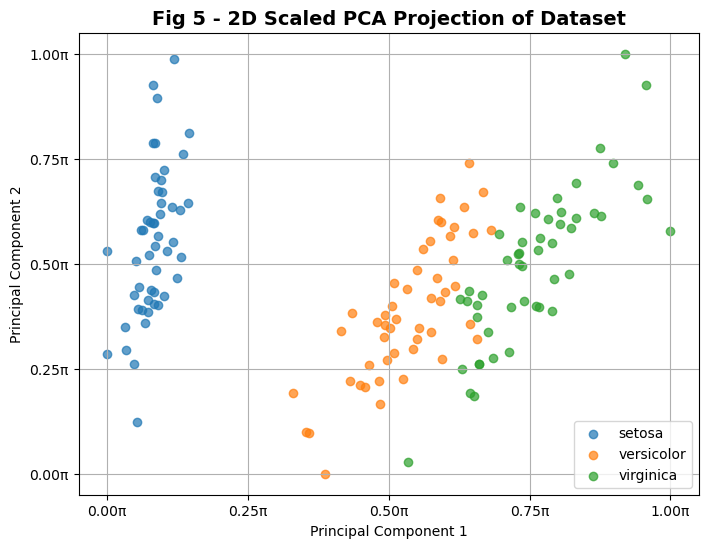

In [12]:
# Scaling the data from 0 to pi using sklearns MinMaxScaler()
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_pca_s = scaler.fit_transform(X_pca)
X = scaler.fit_transform(X)

# Plot the scaled data with radian ticks:
scatter_plot_2d_data(X_pca_s, y, "Principal Component 1", "Principal Component 2", "Fig 5 - 2D Scaled PCA Projection of Dataset", True)

---

&nbsp;

#### Splitting the data:

After scaling the data, we can at last split it via sklearns `train_test_split()` function:

In [13]:
# Split the training data once for PCA reduced & scaled X and 
# once for non-PCA reduced & scaled X. This is because some circuits like
# RealAmp needs the the feature space to be of equal size as number of qubits.
X_train_pca_s, X_val_test_pca_s, y_train_pca_s, y_val_test_pca_s = train_test_split(X_pca_s, y, test_size=0.30, random_state=55, stratify=y)
X_validation_pca_s, X_test_pca_s, y_validation_pca_s, y_test_pca_s = train_test_split(X_val_test_pca_s, y_val_test_pca_s, test_size=0.50, random_state=55, stratify=y_val_test_pca_s)

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.30, random_state=55, stratify=y)
X_validation, X_test, y_validation, y_test = train_test_split(X_val_test, y_val_test, test_size=0.50, random_state=55, stratify=y_val_test)

---

&nbsp;

### Model selection / Circuit creation

#### Circuit Creation

##### Circuit 1:

In the following code block we will define our first `IrisQNN_RealAmp` class which is a Quantum Neural Network "circuit" which is based on the circuit defined as Real Amplitudes by IBM. For more information look at the report.

[2.42620815 1.28769502 2.51605894 1.57796453]


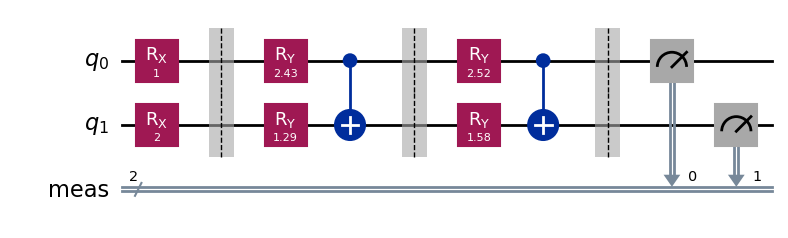

In [14]:
class IrisQNN_RealAmp:
    '''
    Class representing an implementation of the
    Real Amplitudes QNN.

    Attributes:
        - n_qubits (Int): Number of qubits in the QNN.
        - n_layers (Int): Number of layers to the variational part.
        - n_params (Int): Number of parameters to the variational layer(s).
        - param_values (List[Float]): List of actual values to assign to the parameter vectors.
        - params (ParameterVector): Parameter vectors used to assign values for the variational layer(s).
        - qc (QuantumCircuit): The actual QNN / Quantum circuit

    Functions:
        - create_circuit(): Creates the QNN
        - _angle_encoding(): Priv. func to angle encode datapoint. 
        - _add_variational_layer_real_amplitude(): Priv. func to add variational layer.
        - get_parameter_count(): Func to retrieve number of params in current circuit.
    '''
    
    def __init__(self, n_qubits, n_layers):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_params = n_qubits * n_layers
        self.param_values = None
        self.params = None
        self.qc = None
        
        
    def create_circuit(self, input_features):
        '''
        A function for creating a Real Amp. circuit
        with the set parameters

        Parameters:
        - input_features (List[Float]): List of input_features to encode 
        
        Calls:
        - _angle_encoding()
        - _add_variational_layer_real_amplitude()
        '''
        # Initialize Quantum Circuit with new params and apply angle encoding:
        qc = QuantumCircuit(self.n_qubits)
        self.params = ParameterVector('θ', self.n_params)
        self._angle_encoding(qc, input_features)
        
        # For each layer, add a variational layer:
        for layer in range(self.n_layers):
            self._add_variational_layer_real_amplitude(qc, layer)
        
        # Add measurement in the end
        qc.measure_all()
        
        self.qc = qc
        
    
    def _angle_encoding(self, qc, input_features):
        '''
        A function to angle encode the qubits at init.
        of the Real Amp. circuit
        
        Parameters:
        - qc (QuantumCircuit): Circuit to apply encoding layer to
        - input_features(List[Float]): List of features to encode
        '''
        # For each qubit, add Rx-Gate for encoding
        for qubit in range(qc.num_qubits):
            qc.rx(input_features[qubit], qubit)
        qc.barrier()

    
    def _add_variational_layer_real_amplitude(self, qc, layer_idx):
        '''
        A function for applying a variational layer to
        the Real Amp. Circuit
               
        Parameters:
        - qc (QuantumCircuit): Circuit to apply var. layer to
        - layer_idx(Int): The index of the current layer
        '''
        # Param offset to shift to next layer
        param_offset = layer_idx * self.n_qubits
        
        # Add Ry-Gate to each qubit with set of params
        for i in range(self.n_qubits):
            qc.ry(self.params[param_offset + i], i)
        
        # Add CX-Gate for entanglement
        for i in range(self.n_qubits - 1):
            qc.cx(i, i+1)
            
        # Add barrier after each "variational" part:
        if layer_idx < self.n_layers - 1:
            qc.barrier()

    
    def get_parameter_count(self):
        '''Getter function for returning the parameter count'''
        return self.n_params
    

    
# Quick seethrough to see that we have managed to:
IrisQNN = IrisQNN_RealAmp(2,2)
IrisQNN.create_circuit([1,2])
IrisQNN.param_values = np.random.uniform(0, np.pi, 4)
IrisQNN.qc.assign_parameters({IrisQNN.params: IrisQNN.param_values},  inplace=True)

print(IrisQNN.param_values)
IrisQNN.qc.draw('mpl')

---

&nbsp;

##### Circuit 2:

In the following code block we will define our second circuit, namely `QuantumFeedForwardNN`. This class tries to model a structure where each qubit intend to function as a neuron, and unitary operators act as weights between the layers. For more information look at the report.

[2.77017708 2.71022314 0.83114549 1.9593049 ]


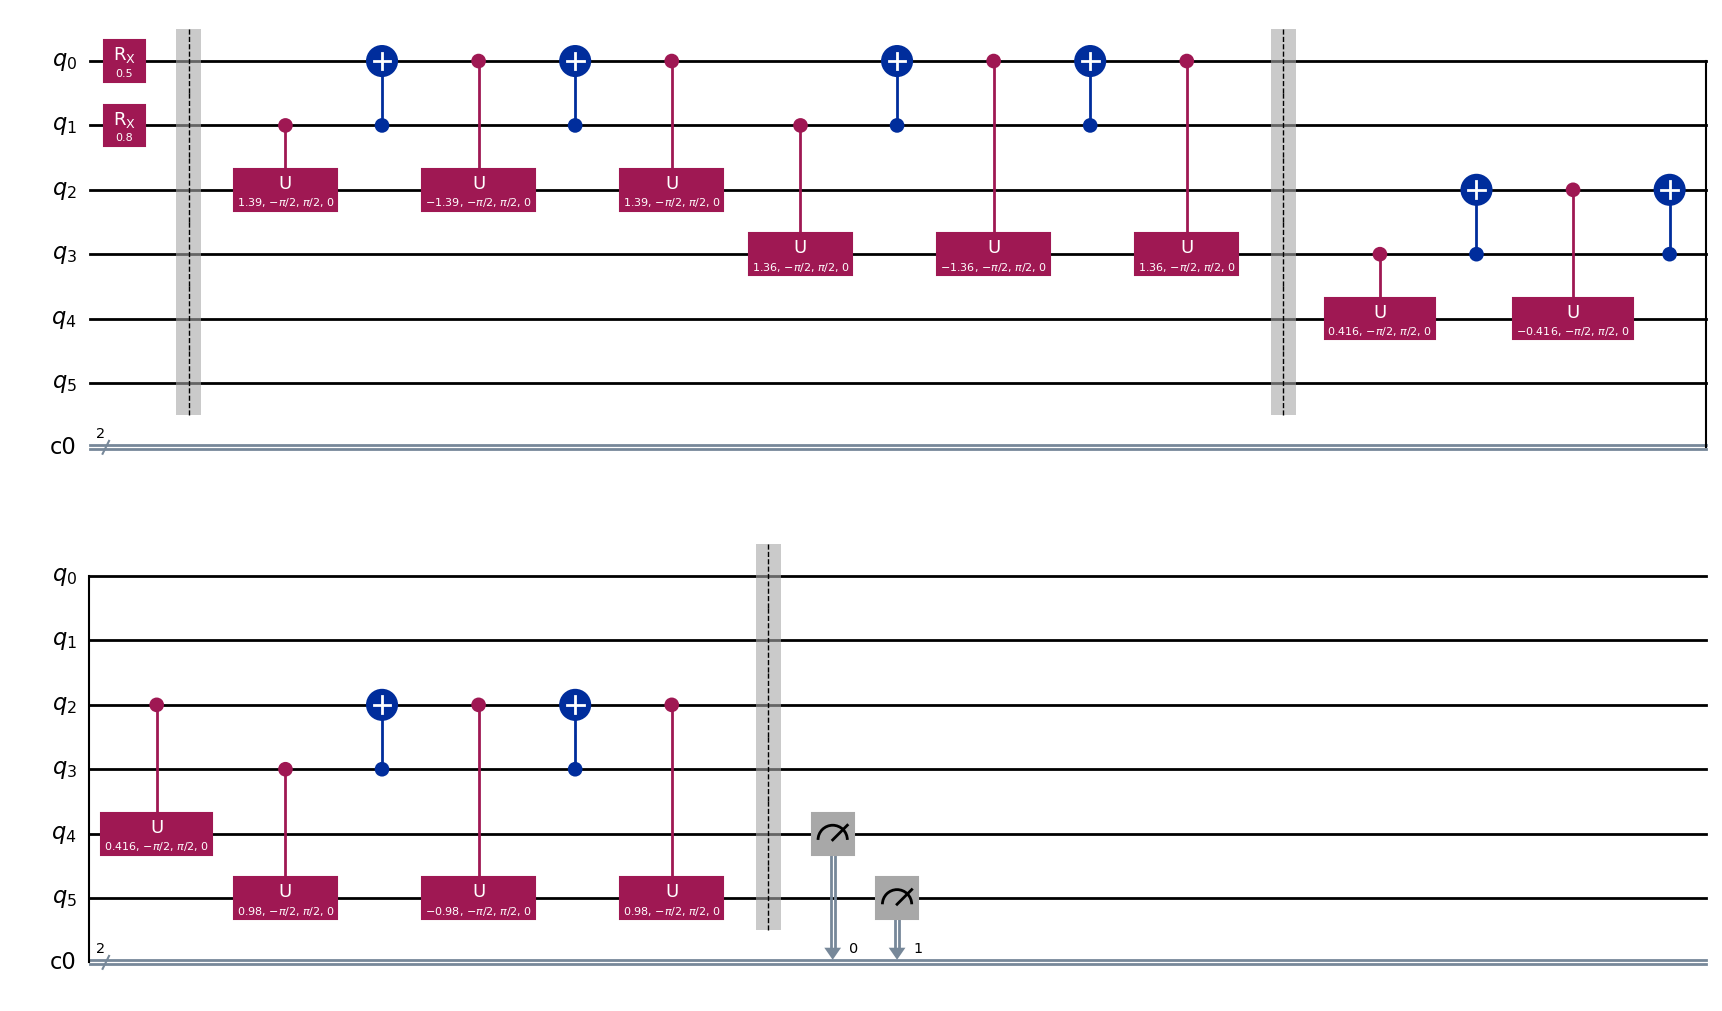

In [15]:
class QuantumFeedForwardNN:
    def __init__(self, n_qubits, n_layers, layer_size, gate_type = "rx"):
        """
        Class potraying a "FeedForward" Quantum Neural Network.
        
        Parameters:
        - n_qubits (Int): Total number of qubits in the circuit.
        - n_layers (Int): Number of layers in the network.
        - layer_size (Int): Number of qubits in each feed-forward layer.
        - gate_type (Str): Type of rotational gate to be used during feed forward layer creation.
        - n_params (Int): Number of params in the Ansatz
        - param_values (List[Float]): List of actual values to assign to the parameter vectors.
        - params (ParameterVector): Parameter vectors used to assign values for the variational layer(s).
        - qc (QuantumCircuit): The actual QNN / Quantum circuit
        """
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.layer_size = layer_size
        self.gate_type = gate_type
        self.n_params = n_qubits - layer_size
        self.param_values = None
        self.params = None
        self.qc = None
    
    def _angle_encoding(self, qc, input_features):
        '''
        A function to angle encode the qubits at init.
        of the QFFNN. circuit
        
        Parameters:
        - qc (QuantumCircuit): Circuit to apply encoding layer to
        - input_features(List[Float]): List of features to encode
        '''
        num_encoded_qubits = len(input_features)
        for i in range(num_encoded_qubits):
            qc.rx(input_features[i], i)
        qc.barrier()

    def _add_feed_forward_layer(self, qc):
        """
        Adds a feed-forward layer with parameterized gates that transfer information to the next layer.
    
        Parameters:
        - qc (QuantumCircuit): The circuit to which the layer is added.
       """
        param_index = 0
        # Apply parameterized controlled gates from each qubit in the current layer to the next layer's qubits
        for i in range(0, self.n_qubits-self.layer_size, self.layer_size):
            control_qubits = list(range(i, self.layer_size+i))
            for j in range(self.layer_size):
                target_qubit = i + self.layer_size + j # Choose the next qubit as target
                param = self.params[param_index]
                self._apply_gate(qc, param, control_qubits, target_qubit)
                param_index += 1
            qc.barrier()
    
    def _add_output_layer(self, qc):
        """
        Function for adding the output layer to the circuit.
        
        Parameters:
        - qc (QuantumCircuit): Circuit to apply output layer to.
        """
        qc.add_register(ClassicalRegister(self.layer_size))
        for i in range(self.n_qubits - self.layer_size, self.n_qubits):
            qc.measure(i, i - (self.n_qubits - self.layer_size))

    def _apply_gate(self, qc, param, control_qubits, target_qubit):
        """
        Applies the chosen gate type with the given parameter.
        
        Parameters:
        - qc (QuantumCircuit): The circuit to which the gate is added.
        - control_qubits (list): Control qubits for the gate.
        - target_qubit (int): The target qubit for the gate.
        - param (Parameter): The parameter for the gate.
        """
        if self.gate_type == 'rx':
            qc.mcrx(param, control_qubits, target_qubit)
        elif self.gate_type == 'ry':
            qc.mcry(param, control_qubits, target_qubit)
        else:
            raise ValueError(f"Unsupported gate type: {self.gate_type}")

    def create_circuit(self, input_features): 
        """
        Creates the Quantum Neural Network circuit.
        
        Parameters:
        - input_features(List[Float]): List of features to encode
        """
        qc = QuantumCircuit(self.n_qubits)
        
        self.params = ParameterVector('θ', self.n_params)
        self._angle_encoding(qc, input_features)
        self._add_feed_forward_layer(qc) 
        self._add_output_layer(qc)
        self.qc = qc


# Quick seethrough to see that we have managed to:
IrisQNN2 = QuantumFeedForwardNN(6, 3, 2, "rx")
IrisQNN2.create_circuit([0.5, 0.8])
IrisQNN2.param_values = np.random.uniform(0, np.pi, IrisQNN2.n_params)
IrisQNN2.qc.assign_parameters({IrisQNN2.params: IrisQNN2.param_values}, inplace=True) 

print(IrisQNN2.param_values)
IrisQNN2.qc.draw('mpl')

&nbsp;

#### Training our Circuits:

In the following stage we will train our circuits. This training is conducted with regards to a specificed loss function given to our "training" class. Below we will define our training class `train_QNN` which is utilized to train models in epochs and batches. But first, we define our loss functions. We do this via specifying a class `Loss_functions` which can hold different loss functions:

In [16]:
class Loss_functions:
    '''
    Class defining loss functions for usage in our training class
    
    Functions:
    - compute_loss_CE(): Loss function for computing Categorical Cross Entropy.
    '''
    
    #def compute_loss_CE(self, predicted, actual):
    #    '''Compute Categorical Cross Entropy Loss'''
    #    # Epsilon to ensure we never encounter log(0)
    #    eps = 1e-10
    #    return -np.sum([i*np.log(j if j != 0 else j+eps) for i,j in zip(actual, predicted)])
    
    def compute_loss_CE(self, predicted, actual):
        return log_loss(actual, predicted)

---

&nbsp;

Secondly, we define our training class `Train_QNN` which has three main functions to train QNN´s. This is specifically single datapoint, mini-batch and full-batch updates:

In [17]:
class Train_QNN:
    '''
    A training class for training a given Quantum Neural Network
    given number of epochs and batches.
    
    Parameters:
    - X (np.array): Current training set to train model / calculate loss on
    - y (np.array): Corresponding labels to the training set
    - X_val (np.array): Current validation set to calculate loss
    - y_val (np.array): Corresponding labels to the validation set
    - QNN (QuantumCircuit): QNN to train
    - loss_func (Loss_functions): Loss function class with loss functions to utilize
    - n_epochs (Int): Number of epochs to run
    - n_batches (Int): Number of batches to run
    - backend (QasmSimulator): Backend to simulate the circuit on
    - patience (Int): Patience before ending current training
    - momentum (Float): Momentum of last gradients
    - best_val_loss (Float): Best validation loss so far
    - best_params (List[Float]): Best parameters retrieved after best validation loss
    - no_improvement_count (Int): Counter for testing patience
    - velocity (np.array): Current velocity calculated from learning rate and momentum
    
    Functions:
       Main functions:
    - train_single_datapoint_upd_new(): Initializes a training session with single datapoint gradient updates.
    - train_mini_batch_updates_new(): --||-- with mini batch avg. gradient updates
    - train_full_batch_updates_new(): --||-- with full batch avg. gradient updates
    
       Helper functions:
    - _train_loss(): Calculate current training loss
    - _val_loss(): Calculate current validation loss
    - _exec_circuits(): Execute circuit
    - _initialize_params(): Initialize start params of ansatz
    - _set_params(): Set params of ansatz to specified params
    - _update_param_vals(): Take a step in the negative direction of gradient
    - _bin_decode(): Binary decode the current prediction using modulo calculations
    - _finiteDifference(): Estimate the gradient using finite difference method
    '''
    def __init__(self, X, y, X_val, y_val, QNN, loss_func, n_epochs, n_batches, patience = 3, momentum = 0.9):
        self.X = X
        self.y = y
        self.X_val = X_val
        self.y_val = y_val
        self.QNN = QNN
        self.loss_func = loss_func
        self.n_epochs = n_epochs
        self.n_batches = n_batches
        self.backend = QasmSimulator()
        np.random.seed(42)
        
        # Early stopping and momentum parameters
        self.patience = patience
        self.momentum = momentum
        self.best_val_loss = float('inf')
        self.best_params = None
        self.no_improvement_count = 0
        self.velocity = np.zeros_like(self.QNN.param_values)    
     
    
    
################################################## MAIN FUNCTIONS #################################################

    def train_single_datapoint_upd_new(self, shots=1000, learning_rate=0.1, eps=0.1):
        print(f"#### INITIALIZING TRAINING (single datapoint updates) #####")
        start_total = t.time()
        
        # Run n_batches for each epoch
        loss_list_train = np.zeros(self.n_epochs)
        loss_list_val = np.zeros(self.n_epochs)
        
        for epoch in range(self.n_epochs):
            start = t.time()
                
            #self.QNN.create_circuit(epoch)
            # Initialize start params 
            #if (epoch == 0):
            #    self._initialize_params()
            #else:
            #    self._set_params(self.QNN.param_values, False)
            #    
            #gradients = self._finiteDifference(eps, epoch)
            #self._update_param_vals(learning_rate=learning_rate, gradients=gradients)
            
            for batch in range(len(self.X)):
                self.QNN.create_circuit(self.X[batch])
                # Initialize start params 
                if (epoch == 0 and batch == 0):
                    self._initialize_params()
                else:
                    self._set_params(self.QNN.param_values, False)

                gradients = self._finiteDifference(eps, batch)
                self._update_param_vals(learning_rate=learning_rate, gradients=gradients)
                
            # Update loss at the end of each epoch & Early stopping check
            train_loss = self._train_loss(shots)
            loss_list_train[epoch] = train_loss
            
            val_loss = self._val_loss(shots)
            loss_list_val[epoch] = val_loss
            
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_params = self.QNN.param_values.copy()
                self.no_improvement_count = 0
            else:
                self.no_improvement_count += 1
            
            # Check if patience is exceeded
            if self.no_improvement_count >= self.patience:
                end = t.time()
                print(f"Early stopping at Epoch {epoch + 1} (Time used: {(end-start)/60:.2f} min)")
                print(f"Epoch stats:\n --- Training loss: {train_loss:.3f}\n --- Validation Loss: {val_loss:.3f}\n")
                break
            
            end = t.time()
            print(f"Epoch {epoch+1} Finished (Time used: {(end-start)/60:.2f} min)")
            print(f"Epoch stats:\n --- Training loss: {train_loss:.3f}\n --- Validation Loss: {val_loss:.3f}\n")
        
        
        end_total = t.time()
        print(f"Training finished! (Time used: {(end_total-start_total)/60:.2f} min)")
        print(f"#### TRAINING ENDED (single datapoint updates) ##### \n\n\n")
            
        return loss_list_train, loss_list_val
    
    
    
      
    def train_mini_batch_updates_new(self, shots=1000, learning_rate=0.1, eps=0.1,  batch_size=10, full_batch=False):
        if not full_batch:
            print(f"#### INITIALIZING TRAINING (mini batch updates) #####")
        else:
            print(f"#### INITIALIZING TRAINING (full batch updates) #####")
        start_total = t.time()
        # Run n_batches for each epoch
        loss_list_train = np.zeros(self.n_epochs)
        loss_list_val = np.zeros(self.n_epochs)
        
        for epoch in range(self.n_epochs):
            start = t.time()
            
            # Define batch size, shuffle and compute batches for each epoch
            indices_train = np.random.permutation(len(self.X))
            
            X_shuffled = self.X[indices_train]
            y_shuffled = self.y[indices_train]
            
            batches = [X_shuffled[i:i + batch_size] for i in range(0, len(X_shuffled), batch_size)]
            
            for batch_nr, batch in enumerate(batches):
                
                gradients = []
                for datapoint_idx, datapoint in enumerate(batch):
                    # Initialize QNN with current "input_values" for encoding:
                    self.QNN.create_circuit(datapoint)

                    # Initialize start params:
                    if (epoch == 0 and batch_nr == 0):
                        self._initialize_params()
                    else:
                        self._set_params(self.QNN.param_values, False)
                    
                    gradients.append(self._finiteDifference(eps, indices_train[(batch_nr*batch_size)+datapoint_idx]))
                
                avg_gradients = np.mean(gradients, axis=0)
                self._update_param_vals(learning_rate=learning_rate, gradients=avg_gradients)
                
                
            # Update loss at the end of each epoch & Early stopping check
            train_loss = self._train_loss(shots)
            loss_list_train[epoch] = train_loss
            
            val_loss = self._val_loss(shots)
            loss_list_val[epoch] = val_loss
            
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_params = self.QNN.param_values.copy()
                self.no_improvement_count = 0
            else:
                self.no_improvement_count += 1
            
            # Check if patience is exceeded
            if self.no_improvement_count >= self.patience:
                end = t.time()
                print(f"Early stopping at Epoch {epoch + 1} (Time used: {(end-start)/60:.2f} min)")
                print(f"Epoch stats:\n --- Training loss: {train_loss:.3f}\n --- Validation Loss: {val_loss:.3f}\n")
                break
            
            end = t.time()
            print(f"Epoch {epoch+1} Finished (Time used: {(end-start)/60:.2f} min)")
            print(f"Epoch stats:\n --- Training loss: {train_loss:.3f}\n --- Validation Loss: {val_loss:.3f}\n")
            
        end_total = t.time()
        print(f"\nTraining finished! (Time used: {(end_total-start_total)/60:.2f} min)")
        if not full_batch:
            print(f"#### TRAINING ENDED (mini batch updates) ##### \n\n\n")
        else:
            print(f"#### TRAINING ENDED (full batch updates) ##### \n\n\n")
            
        return loss_list_train, loss_list_val
    
    
    
    
    def train_full_batch_updates_new(self, shots=1000, learning_rate=0.1, eps=0.1):
        return self.train_mini_batch_updates_new(shots, learning_rate, eps, batch_size=len(self.X), full_batch=True)
    
    
    
################################################ HELPER FUNCTIONS #################################################

    def _train_loss(self, shots = 1000):
        train_loss = []
        for datapoint_idx, datapoint in enumerate(self.X):
            self.QNN.create_circuit(datapoint)
            self._set_params(self.QNN.param_values, True)
            actual, decoded_result = self._bin_decode(self._exec_circuit(shots=shots), datapoint_idx, shots, val=False)
            train_loss.append(self.loss_func.compute_loss_CE(decoded_result, actual))

        return np.mean(train_loss)


    def _val_loss(self, shots = 1000):
        val_loss = []
        for datapoint_idx, datapoint in enumerate(self.X_val):
            self.QNN.create_circuit(datapoint)
            self._set_params(self.QNN.param_values, True)
            actual, decoded_result = self._bin_decode(self._exec_circuit(shots=shots), datapoint_idx, shots, val=True)
            val_loss.append(self.loss_func.compute_loss_CE(decoded_result, actual))
            
        return np.mean(val_loss)
        
        
    def _initialize_params(self):
        init_params = np.random.uniform(0, np.pi, self.QNN.n_params)
        self._set_params(init_params, False)
        
        
    def _set_params(self, params, grad_descent):
        if not grad_descent:
            self.QNN.param_values = params
        self.QNN.qc.assign_parameters({self.QNN.params: params}, inplace=True)
        
    #def _update_param_vals(self, gradients, learning_rate):
    #    self.QNN.param_values = self.QNN.param_values - (learning_rate * np.array(gradients))
    
    # New update func with momentum:
    def _update_param_vals(self, gradients, learning_rate):
        self.velocity = self.momentum * self.velocity + (1 - self.momentum) * np.array(gradients)
        self.QNN.param_values -= (learning_rate * self.velocity)
        
        
    def _exec_circuit(self, shots=1000):
        transpiled_qc = transpile(self.QNN.qc, self.backend)
        job = self.backend.run(transpiled_qc, shots=shots)
        return job.result()
    
    def _bin_decode(self, result, y_idx, shots=1000, val=False):
        counts = result.get_counts(self.QNN.qc)        # counts from the execution of the circuit
        probabilities = np.zeros(3)                    # array to store the probabilities of the classes

        for bitstring, count in counts.items():
            classIndex = int(bitstring, 2) % 3         # convert bitstring to integer 0, 1 or 2
            probabilities[classIndex] += count         # add the probability of the class

        probabilities /= np.sum(probabilities)         # Ensuring normalization
        actual = np.zeros(3)
        
        if not val:
            actual[self.y[y_idx]] = 1
        else:
            actual[self.y_val[y_idx]] = 1
        
        return actual, probabilities
    
    
    def _finiteDifference(self, epsilon, batch):
        # if (decode == binary and loss == CrossEntropy): 
        # Initialize list for holding gradients:
        gradients = []
        
        # Loop through all params and retrieve curr gradient:
        for i in range(self.QNN.n_params):
            forward, backward = np.copy(self.QNN.param_values), np.copy(self.QNN.param_values)
            forward[i], backward[i] = forward[i]+epsilon, backward[i]-epsilon
            
            self.QNN.create_circuit(X[batch])
            self._set_params(forward, True)
            actual, decoded_result = self._bin_decode(self._exec_circuit(shots=1000), batch)
            loss_forward = self.loss_func.compute_loss_CE(decoded_result, actual)
            
            self.QNN.create_circuit(X[batch])
            self._set_params(backward, True)            
            actual, decoded_result = self._bin_decode(self._exec_circuit(shots=1000), batch)
            loss_backward = self.loss_func.compute_loss_CE(decoded_result, actual)
            
            gradients.append((loss_forward - loss_backward) / (2 * epsilon))
        
        return gradients

&nbsp;

---

#### Visualizing and searching for optimal parameters:

At last we make a loss visualization, search and iter function. These functions combined makes it easy for us to try different parameters for each and every type of update. `Visualize_loss()` utilizes `remove_trailing_zeros()` to visualize the loss curve for each model trained:

In [18]:
### VIZ LOSS ###
def remove_trailing_zeros(loss_list):
    # Find the index of the last non-zero element
    last_non_zero = len(loss_list) - 1
    while last_non_zero >= 0 and loss_list[last_non_zero] == 0:
        last_non_zero -= 1
    # Return the list up to the last non-zero element
    return loss_list[:last_non_zero + 1]

def visualize_loss(loss_list1, loss_list2, x_text, y_text, title, val_aswell = False):
    loss_list1 = remove_trailing_zeros(loss_list1)
    loss_list2 = remove_trailing_zeros(loss_list2)
    
    plt.figure(figsize=(12, 10))
    plt.plot(range(1, len(loss_list1) + 1), loss_list1, label="Training Loss", color="blue")
    plt.plot(range(1, len(loss_list2) + 1), loss_list2, label="Validation Loss", color="orange")
    plt.xlabel(x_text)
    plt.xticks(range(1, 41))
    plt.ylabel(y_text)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

&nbsp;

Whereas `search_for_optimal_params()` utilizes the `train_QNN` class to train the specified QNN with specific parameters in single datapoint, mini-batch and full-batch updates. It also utilizes the visualization functions to visualize the loss during training:

In [19]:
def search_for_optimal_params(num_qubits = 2, num_layers = 2, learning_rate = 0.1, realAMP = True):
    params_retrieved = {
        "mini_batch":[],
        "full_batch":[],
        "single_datapoint":[],
                       }
    
    x = num_qubits
    y = num_layers
    z = learning_rate
    
    if realAMP:
        name = f"REAL AMP CIRC.: Num_qubits: {x} num_layers: {y} learning_rate: {z}"
        print(f"Current search:\nPARAMS (REAL AMP CIRC.): Qubits {x}, Layers {y}, Learning rate {z} \n\n")
    else:
        name = f"QUANTUM FF CIRC.: Num_qubits: {x} num_layers: {y} layer_size: 2 learning_rate: {z}"
        print(f"Current search:\nPARAMS (QUANTUM FF CIRC.): Qubits {x}, Layers {y}, Learning rate {z} \n\n")
    
    if x == 2 or not realAMP: 
        X_1, y_1, X_2, y_2 = X_train_pca_s, y_train_pca_s, X_validation_pca_s, y_validation_pca_s
    else:
        X_1, y_1, X_2, y_2 = X_train, y_train, X_validation, y_validation 

    
    loss_func_cl = Loss_functions()
    
    if realAMP: 
        myQNN = IrisQNN_RealAmp(x, y)
    else:
        # TODO:
        myQNN = QuantumFeedForwardNN(x, y, 2)
                
    print("###################################################################")
    print("#             TESTING TRAINING (single datapoint update):         #")
    print("###################################################################")
    trainer1 = Train_QNN(X_1, y_1, X_2, y_2, myQNN, loss_func_cl,
                         30, len(X_train), patience = 10, momentum = 0.9)
    loss_list_single_datapoint_train, loss_list_single_datapoint_val = trainer1.train_single_datapoint_upd_new(1000, z, 0.1)
    visualize_loss(np.array(loss_list_single_datapoint_train).flatten().tolist(),
                   np.array(loss_list_single_datapoint_val).flatten().tolist(),
                   "Epoch", "Loss", "Training Loss per Epoch (Single datapoint updates)")
                    
    print("###################################################################")
    print("#               TESTING TRAINING (minibatch updates):             #")
    print("###################################################################")
    trainer2 = Train_QNN(X_1, y_1, X_2, y_2, myQNN, loss_func_cl,
                         30, len(X_train), patience = 10, momentum = 0.9)
    loss_list_mini_batches_train, loss_list_mini_batches_val  = trainer2.train_mini_batch_updates_new(1000, z, 0.1, 10)
    visualize_loss(np.array(loss_list_mini_batches_train).flatten().tolist(),
                   np.array(loss_list_mini_batches_val).flatten().tolist(),
                   "Epoch", "Loss", "Training Loss per Epoch (Mini batches)")
                
                                                                                                              
    print("###################################################################")
    print("#               TESTING TRAINING (fullbatch updates):             #")
    print("###################################################################")
    trainer3 = Train_QNN(X_1, y_1, X_2, y_2, myQNN, loss_func_cl,
                         30, len(X_train), patience = 10, momentum = 0.9)
    loss_list_full_batches_train, loss_list_full_batches_val  = trainer3.train_full_batch_updates_new(1000, z, 0.1)
    visualize_loss(np.array(loss_list_full_batches_train).flatten().tolist(),
                   np.array(loss_list_full_batches_val).flatten().tolist(),
                   "Epoch", "Loss", "Training Loss per Epoch (Full batches)")
                                                                                                              
                
    params_retrieved["single_datapoint"].append((trainer1.best_val_loss, trainer1.best_params,
                                           loss_list_single_datapoint_train, loss_list_single_datapoint_val))
                
    params_retrieved["mini_batch"].append((trainer2.best_val_loss, trainer2.best_params,
                                           loss_list_mini_batches_train, loss_list_mini_batches_val))
                
    params_retrieved["full_batch"].append((trainer3.best_val_loss, trainer3.best_params,
                                           loss_list_full_batches_train, loss_list_full_batches_val))
                
                
    return x, y, name, params_retrieved
                

---

&nbsp;

#### Iterating through the params and finding the best performing model:

After utilizing `search_for_optimal_params()` function we define our two last functions, `iterate_params_retrieved()` and `test_best_performing_model()`. These functions print out params and loss for each of the searches and test the best performing model on the test data respectively:

In [20]:
# Function for iterating through the params retrieved
def iterate_params_retrieved(num_qubits, num_layers, name, params_retrieved):
    print(f"---- SEARCH OVER PARAMS: {name} ----\n")
    # Iterate over the keys of params_retrieved (e.g., 'mini_batch', 'full_batch', etc.)
    for batch_type, results_list in params_retrieved.items():
        print(f"\nResults for {batch_type} updates:")
        
        # Iterate over each entry in the results list
        for result in results_list:
            best_val_loss, best_params, train_loss, val_loss = result
            
            print(f"Best Validation Loss: {best_val_loss:.3f}")
            print(f"Best Params: {best_params}")

# Function for finding and testing the best performing model
def test_best_performing_model(list_of_searches):
    best_val_loss = float("inf")
    best_batch_type = ""
    best_params = []
    best_name = ""
    best_num_qubits = 0
    best_num_layers = 0
    
    # For each search in search list, get attributes of the search
    for search in list_of_searches:
        num_qubits, num_layers, name, curr_search = search
        
        # For each batch type and result list, update if val loss
        # is better than best val loss
        for batch_type, results_list in curr_search.items():
            for b_type, result in zip(batch_type, results_list):
                val_loss, params, _, _ = result
                
                if best_val_loss > val_loss:
                    best_val_loss = val_loss
                    best_batch_type = b_type
                    best_params = params
                    best_name = name
                    best_num_qubits = num_qubits
                    best_num_layers = num_layers
                    
    
    # Print out and evaluate the best performing model w.
    # accuracy and confusion matrix.
    output1 = "#   Best Performing Model   #"
    print(len(output1)* "#")
    print(f"{output1}")
    print(len(output1)* "#")
    print(f" --- Params ---\n{best_name}\n")
    print(" --- Variational params ---")
    output_str = ""
    for i, x in enumerate(best_params):
        if (((i+1) % 5) == 0):
            output_str += f" θ_{i+1} = {x:.2f},"
            print(output_str)
            output_str = ""
        elif (i+1) == len(best_params):
            output_str += f" θ_{i+1} = {x:.2f}."
            print(output_str)
        else:
            output_str += f" θ_{i+1} = {x:.2f},"
    
    correct = 0
    num_possible_corr = len(y_test)
    backend = QasmSimulator()
    
    if "REAL AMP CIRC" in best_name:
        myQNN = IrisQNN_RealAmp(best_num_qubits, best_num_layers)
    else:
        myQNN = QuantumFeedForwardNN(x, y, 2)
            
    if best_num_qubits == 2:
        X_test_iter, y_test_iter = X_test_pca_s, y_test_pca_s
    else:
        X_test_iter, y_test_iter = X_test, y_test

    true_l = []
    predicted_l = []
    for curr_X, curr_y in zip(X_test_iter, y_test_iter):
            myQNN.create_circuit(curr_X)
            myQNN.qc.assign_parameters({myQNN.params: best_params}, inplace=True)
            transpiled_qc = transpile(myQNN.qc, backend)
            job = backend.run(transpiled_qc, shots=1000)

            counts = job.result().get_counts(myQNN.qc) 
            probabilities = np.zeros(3)                    

            for bitstring, count in counts.items():
                classIndex = int(bitstring, 2) % 3  
                probabilities[classIndex] += count

            probabilities /= np.sum(probabilities)
            prediction = np.argmax(probabilities)
            
            true_l.append(curr_y), predicted_l.append(prediction)
            if prediction == curr_y:
                correct +=1
    
    print("\n\n --- Accuracy on test data ---")
    print(f"Accuracy: {correct/num_possible_corr:.3f}")
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_l, predicted_l)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[label for label in labels], yticklabels=[label for label in labels])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    

---

&nbsp;


#### Conducting the search

At last, after defining lots of visualisation, search and training classes and functions we can conduct our search using `search_for_optimal_params()` and `iterate_params_retrieved()`:

Current search:
PARAMS (QUANTUM FF CIRC.): Qubits 6, Layers 3, Learning rate 0.5 


###################################################################
#             TESTING TRAINING (single datapoint update):         #
###################################################################
#### INITIALIZING TRAINING (single datapoint updates) #####
Epoch 1 Finished (Time used: 0.47 min)
Epoch stats:
 --- Training loss: 16.019
 --- Validation Loss: 16.383

Epoch 2 Finished (Time used: 0.47 min)
Epoch stats:
 --- Training loss: 2.713
 --- Validation Loss: 2.284

Epoch 3 Finished (Time used: 0.47 min)
Epoch stats:
 --- Training loss: 3.740
 --- Validation Loss: 3.713

Epoch 4 Finished (Time used: 0.48 min)
Epoch stats:
 --- Training loss: 3.637
 --- Validation Loss: 4.190

Epoch 5 Finished (Time used: 0.47 min)
Epoch stats:
 --- Training loss: 5.105
 --- Validation Loss: 5.342

Epoch 6 Finished (Time used: 0.48 min)
Epoch stats:
 --- Training loss: 3.329
 --- Validation Loss: 3.080

Epoch 7 

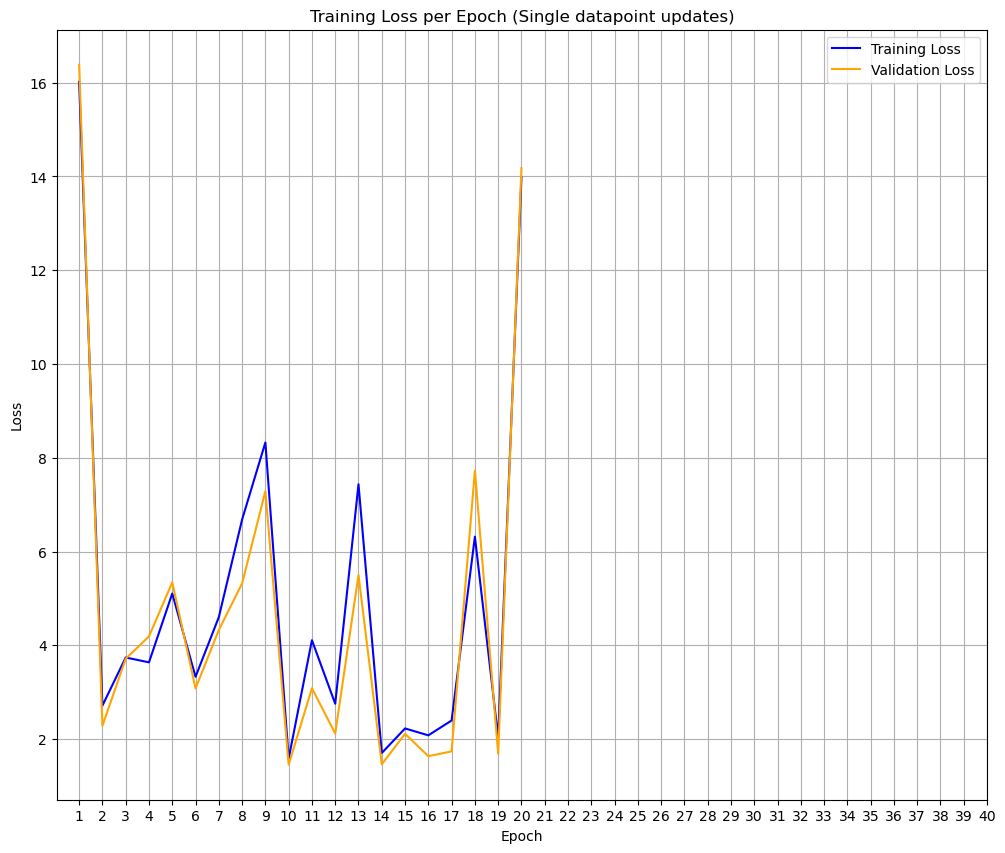

###################################################################
#               TESTING TRAINING (minibatch updates):             #
###################################################################
#### INITIALIZING TRAINING (mini batch updates) #####
Epoch 1 Finished (Time used: 0.47 min)
Epoch stats:
 --- Training loss: 5.183
 --- Validation Loss: 4.755

Epoch 2 Finished (Time used: 0.47 min)
Epoch stats:
 --- Training loss: 15.002
 --- Validation Loss: 15.501

Epoch 3 Finished (Time used: 0.48 min)
Epoch stats:
 --- Training loss: 1.596
 --- Validation Loss: 1.289

Epoch 4 Finished (Time used: 0.47 min)
Epoch stats:
 --- Training loss: 2.293
 --- Validation Loss: 1.368

Epoch 5 Finished (Time used: 0.48 min)
Epoch stats:
 --- Training loss: 14.068
 --- Validation Loss: 14.166

Epoch 6 Finished (Time used: 0.47 min)
Epoch stats:
 --- Training loss: 2.746
 --- Validation Loss: 2.182

Epoch 7 Finished (Time used: 0.48 min)
Epoch stats:
 --- Training loss: 4.113
 --- Validation Lo

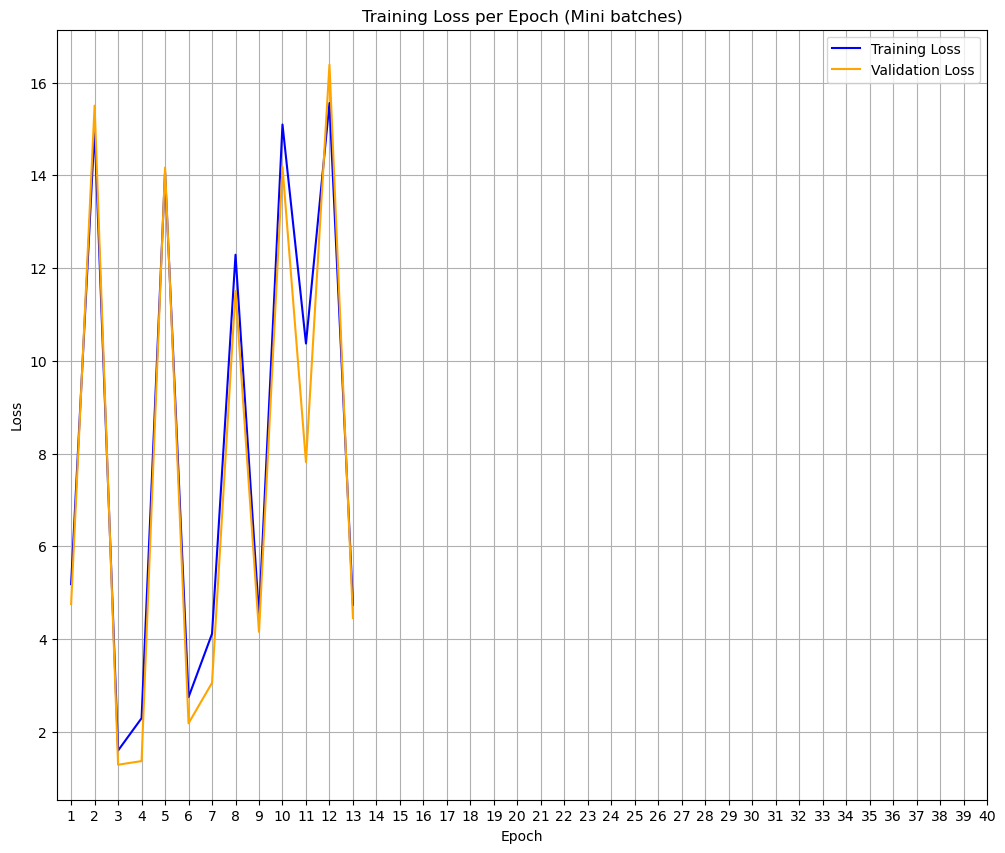

###################################################################
#               TESTING TRAINING (fullbatch updates):             #
###################################################################
#### INITIALIZING TRAINING (full batch updates) #####
Epoch 1 Finished (Time used: 0.48 min)
Epoch stats:
 --- Training loss: 9.408
 --- Validation Loss: 7.342

Epoch 2 Finished (Time used: 0.48 min)
Epoch stats:
 --- Training loss: 15.187
 --- Validation Loss: 15.501

Epoch 3 Finished (Time used: 0.48 min)
Epoch stats:
 --- Training loss: 7.347
 --- Validation Loss: 8.111

Epoch 4 Finished (Time used: 0.48 min)
Epoch stats:
 --- Training loss: 4.511
 --- Validation Loss: 4.312

Epoch 5 Finished (Time used: 0.47 min)
Epoch stats:
 --- Training loss: 4.382
 --- Validation Loss: 3.716

Epoch 6 Finished (Time used: 0.48 min)
Epoch stats:
 --- Training loss: 5.469
 --- Validation Loss: 5.738

Epoch 7 Finished (Time used: 0.47 min)
Epoch stats:
 --- Training loss: 16.019
 --- Validation Los

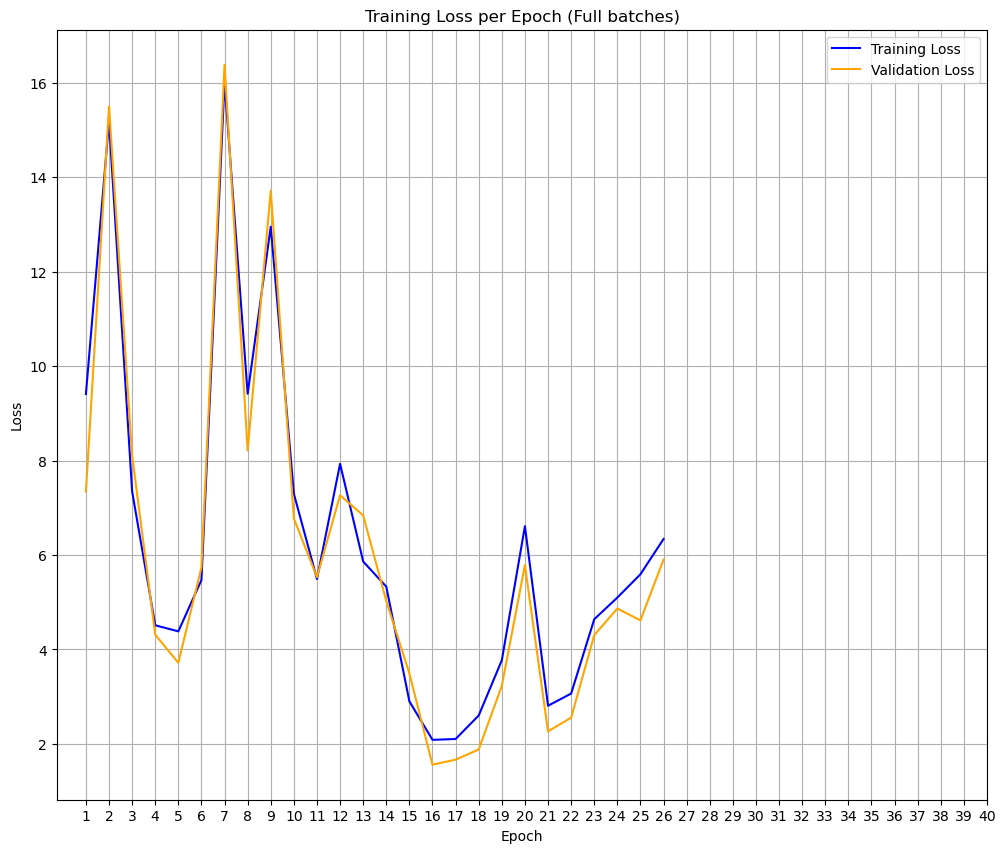

---- SEARCH OVER PARAMS: QUANTUM FF CIRC.: Num_qubits: 6 num_layers: 3 layer_size: 2 learning_rate: 0.5 ----


Results for mini_batch updates:
Best Validation Loss: 1.289
Best Params: [-10.30044499   3.04179519  -4.47060332 -21.28055469]

Results for full_batch updates:
Best Validation Loss: 1.558
Best Params: [ 3.30572577  1.59202796  4.66757841 -0.46239039]

Results for single_datapoint updates:
Best Validation Loss: 1.453
Best Params: [-481.42180487  561.86616191   97.72790037  108.34043831]


In [21]:
list_of_params_retrieved = []

num_qubits_1, num_layers_1, name_1, search_1 = search_for_optimal_params(num_qubits = 6, num_layers = 3, learning_rate = 0.5, realAMP = False)
iterate_params_retrieved(num_qubits_1, num_layers_1, name_1, search_1)
list_of_params_retrieved.append([num_qubits_1, num_layers_1, name_1, search_1])

Current search:
PARAMS (QUANTUM FF CIRC.): Qubits 4, Layers 2, Learning rate 0.5 


###################################################################
#             TESTING TRAINING (single datapoint update):         #
###################################################################
#### INITIALIZING TRAINING (single datapoint updates) #####
Epoch 1 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 1.533
 --- Validation Loss: 1.182

Epoch 2 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 2.495
 --- Validation Loss: 1.932

Epoch 3 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 1.997
 --- Validation Loss: 1.553

Epoch 4 Finished (Time used: 0.27 min)
Epoch stats:
 --- Training loss: 1.768
 --- Validation Loss: 1.768

Epoch 5 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 4.564
 --- Validation Loss: 4.283

Epoch 6 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 1.492
 --- Validation Loss: 1.333

Epoch 7 Fi

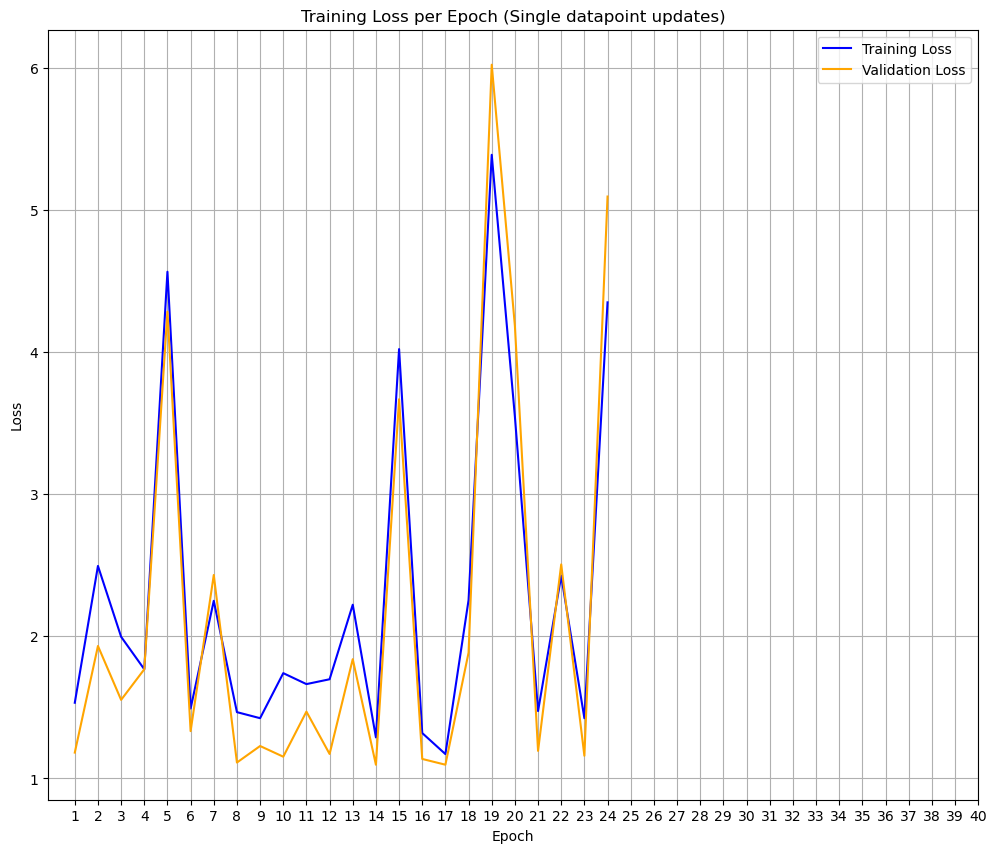

###################################################################
#               TESTING TRAINING (minibatch updates):             #
###################################################################
#### INITIALIZING TRAINING (mini batch updates) #####
Epoch 1 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 1.369
 --- Validation Loss: 1.104

Epoch 2 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 4.210
 --- Validation Loss: 3.559

Epoch 3 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 2.772
 --- Validation Loss: 3.174

Epoch 4 Finished (Time used: 0.27 min)
Epoch stats:
 --- Training loss: 1.571
 --- Validation Loss: 1.072

Epoch 5 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 1.645
 --- Validation Loss: 1.177

Epoch 6 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 1.340
 --- Validation Loss: 1.147

Epoch 7 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 1.369
 --- Validation Loss: 

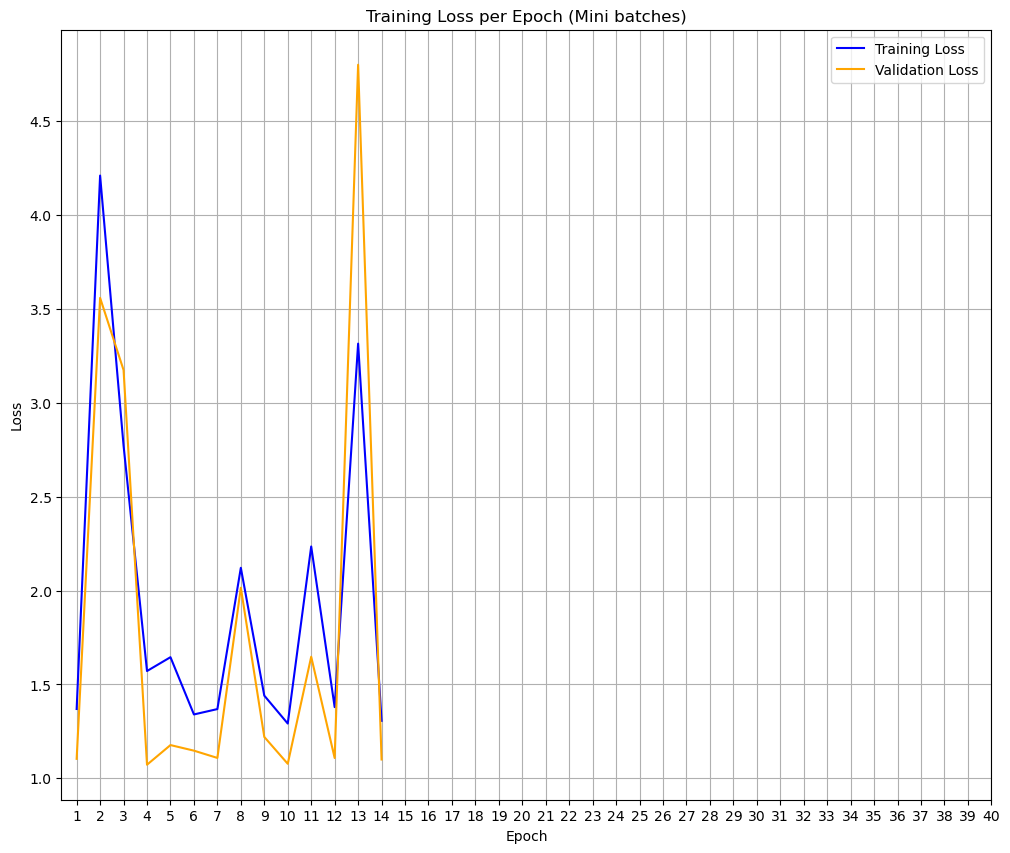

###################################################################
#               TESTING TRAINING (fullbatch updates):             #
###################################################################
#### INITIALIZING TRAINING (full batch updates) #####
Epoch 1 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 4.570
 --- Validation Loss: 4.370

Epoch 2 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 4.838
 --- Validation Loss: 4.372

Epoch 3 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 4.831
 --- Validation Loss: 4.370

Epoch 4 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 4.555
 --- Validation Loss: 4.359

Epoch 5 Finished (Time used: 0.27 min)
Epoch stats:
 --- Training loss: 4.644
 --- Validation Loss: 3.909

Epoch 6 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 4.830
 --- Validation Loss: 4.370

Epoch 7 Finished (Time used: 0.26 min)
Epoch stats:
 --- Training loss: 4.644
 --- Validation Loss: 

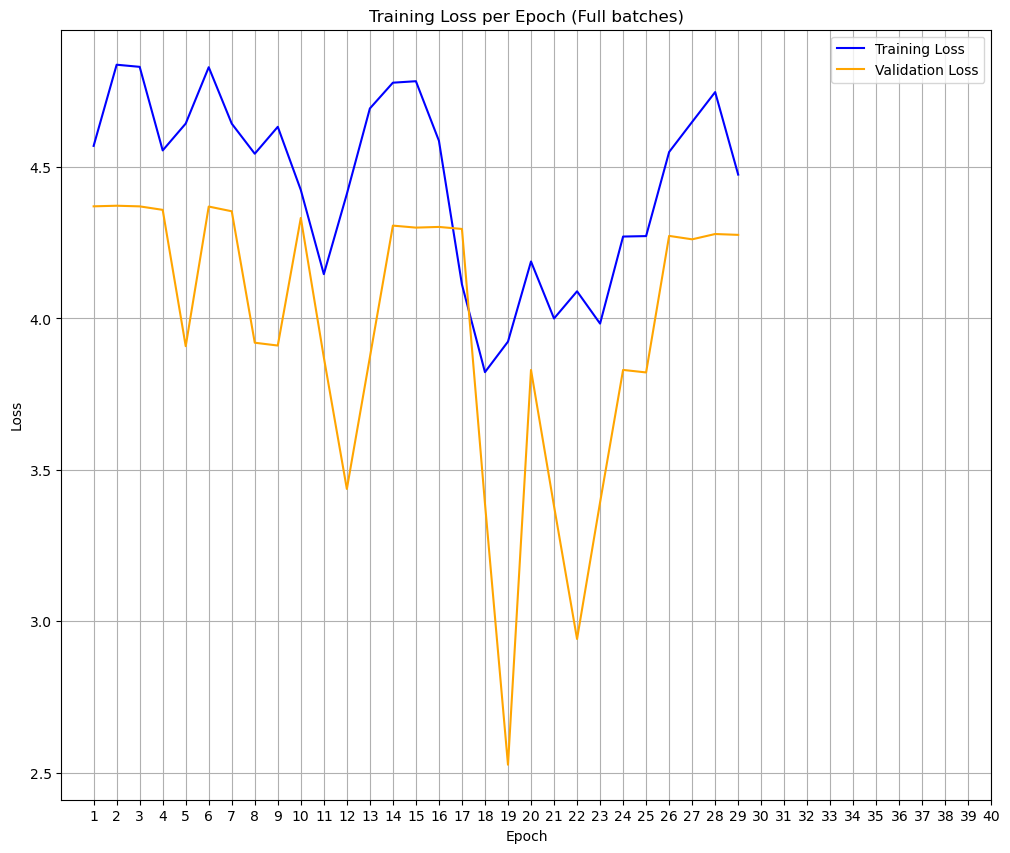

---- SEARCH OVER PARAMS: QUANTUM FF CIRC.: Num_qubits: 4 num_layers: 2 layer_size: 2 learning_rate: 0.5 ----


Results for mini_batch updates:
Best Validation Loss: 1.072
Best Params: [-5.1897048  -2.33947793]

Results for full_batch updates:
Best Validation Loss: 2.526
Best Params: [-0.22379628  2.42060016]

Results for single_datapoint updates:
Best Validation Loss: 1.097
Best Params: [253.03166744 127.51032561]


In [22]:
num_qubits_2, num_layers_2, name_2, search_2 = search_for_optimal_params(num_qubits = 4, num_layers = 2, learning_rate = 0.5, realAMP = False)
iterate_params_retrieved(num_qubits_2, num_layers_2, name_2, search_2)
list_of_params_retrieved.append([num_qubits_2, num_layers_2, name_2, search_2])

Current search:
PARAMS (REAL AMP CIRC.): Qubits 4, Layers 4, Learning rate 0.1 


###################################################################
#             TESTING TRAINING (single datapoint update):         #
###################################################################
#### INITIALIZING TRAINING (single datapoint updates) #####
Epoch 1 Finished (Time used: 1.72 min)
Epoch stats:
 --- Training loss: 0.652
 --- Validation Loss: 0.635

Epoch 2 Finished (Time used: 1.72 min)
Epoch stats:
 --- Training loss: 0.722
 --- Validation Loss: 0.715

Epoch 3 Finished (Time used: 1.72 min)
Epoch stats:
 --- Training loss: 0.964
 --- Validation Loss: 0.977

Epoch 4 Finished (Time used: 1.71 min)
Epoch stats:
 --- Training loss: 1.130
 --- Validation Loss: 1.226

Epoch 5 Finished (Time used: 1.72 min)
Epoch stats:
 --- Training loss: 1.149
 --- Validation Loss: 1.154

Epoch 6 Finished (Time used: 1.71 min)
Epoch stats:
 --- Training loss: 0.905
 --- Validation Loss: 0.891

Epoch 7 Fini

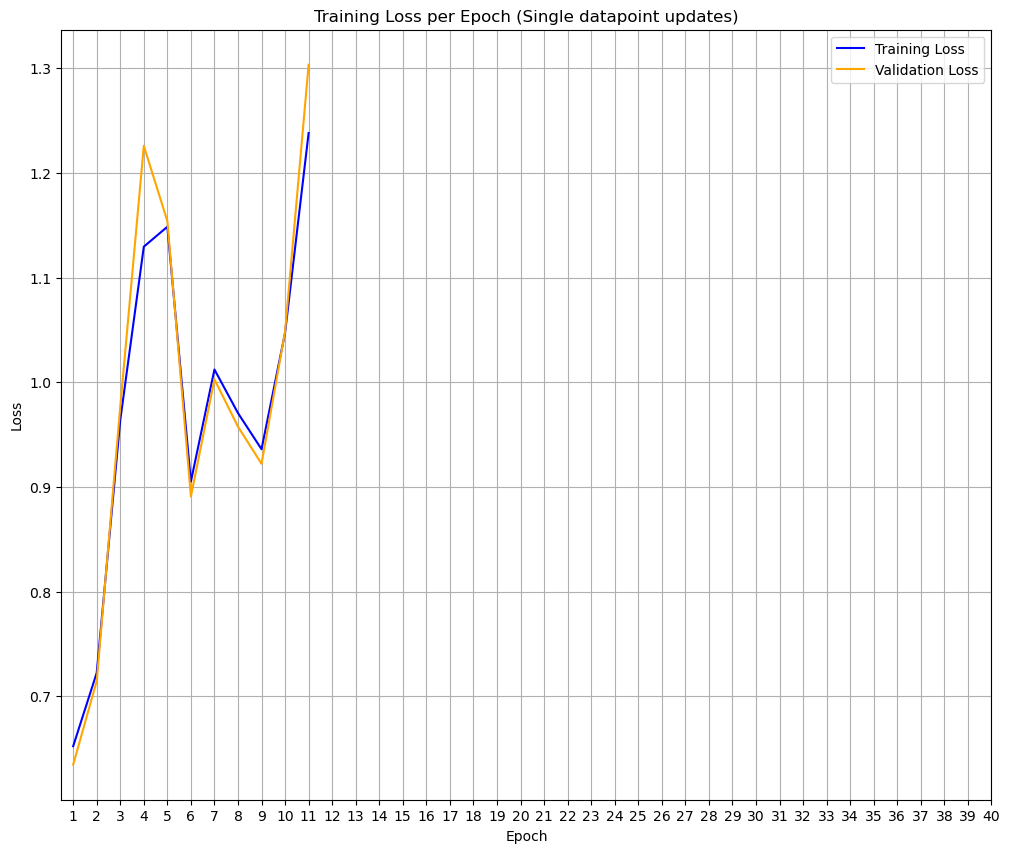

###################################################################
#               TESTING TRAINING (minibatch updates):             #
###################################################################
#### INITIALIZING TRAINING (mini batch updates) #####
Epoch 1 Finished (Time used: 1.71 min)
Epoch stats:
 --- Training loss: 0.598
 --- Validation Loss: 0.607

Epoch 2 Finished (Time used: 1.74 min)
Epoch stats:
 --- Training loss: 0.585
 --- Validation Loss: 0.608

Epoch 3 Finished (Time used: 1.73 min)
Epoch stats:
 --- Training loss: 0.584
 --- Validation Loss: 0.612

Epoch 4 Finished (Time used: 1.73 min)
Epoch stats:
 --- Training loss: 0.569
 --- Validation Loss: 0.593

Epoch 5 Finished (Time used: 1.73 min)
Epoch stats:
 --- Training loss: 0.567
 --- Validation Loss: 0.588

Epoch 6 Finished (Time used: 1.74 min)
Epoch stats:
 --- Training loss: 0.553
 --- Validation Loss: 0.582

Epoch 7 Finished (Time used: 1.72 min)
Epoch stats:
 --- Training loss: 0.545
 --- Validation Loss: 

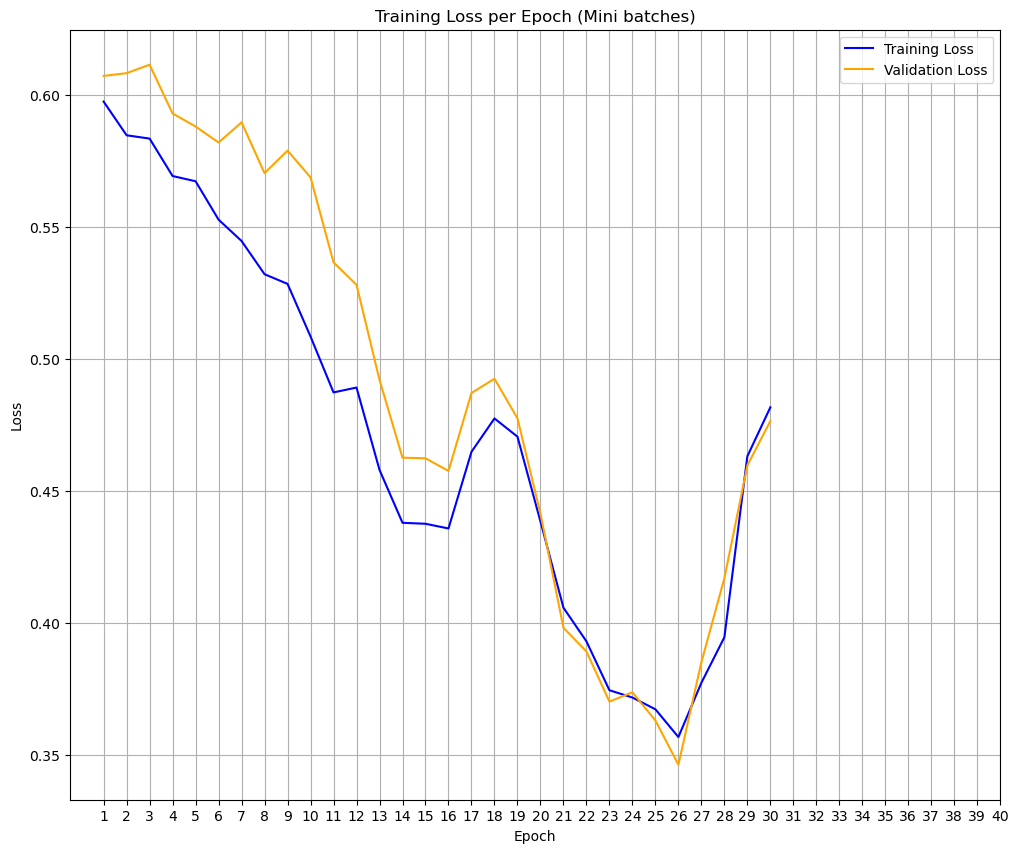

###################################################################
#               TESTING TRAINING (fullbatch updates):             #
###################################################################
#### INITIALIZING TRAINING (full batch updates) #####
Epoch 1 Finished (Time used: 1.73 min)
Epoch stats:
 --- Training loss: 0.646
 --- Validation Loss: 0.652

Epoch 2 Finished (Time used: 1.72 min)
Epoch stats:
 --- Training loss: 0.645
 --- Validation Loss: 0.640

Epoch 3 Finished (Time used: 1.73 min)
Epoch stats:
 --- Training loss: 0.646
 --- Validation Loss: 0.646

Epoch 4 Finished (Time used: 1.73 min)
Epoch stats:
 --- Training loss: 0.645
 --- Validation Loss: 0.650

Epoch 5 Finished (Time used: 1.72 min)
Epoch stats:
 --- Training loss: 0.642
 --- Validation Loss: 0.641

Epoch 6 Finished (Time used: 1.71 min)
Epoch stats:
 --- Training loss: 0.640
 --- Validation Loss: 0.646

Epoch 7 Finished (Time used: 1.73 min)
Epoch stats:
 --- Training loss: 0.643
 --- Validation Loss: 

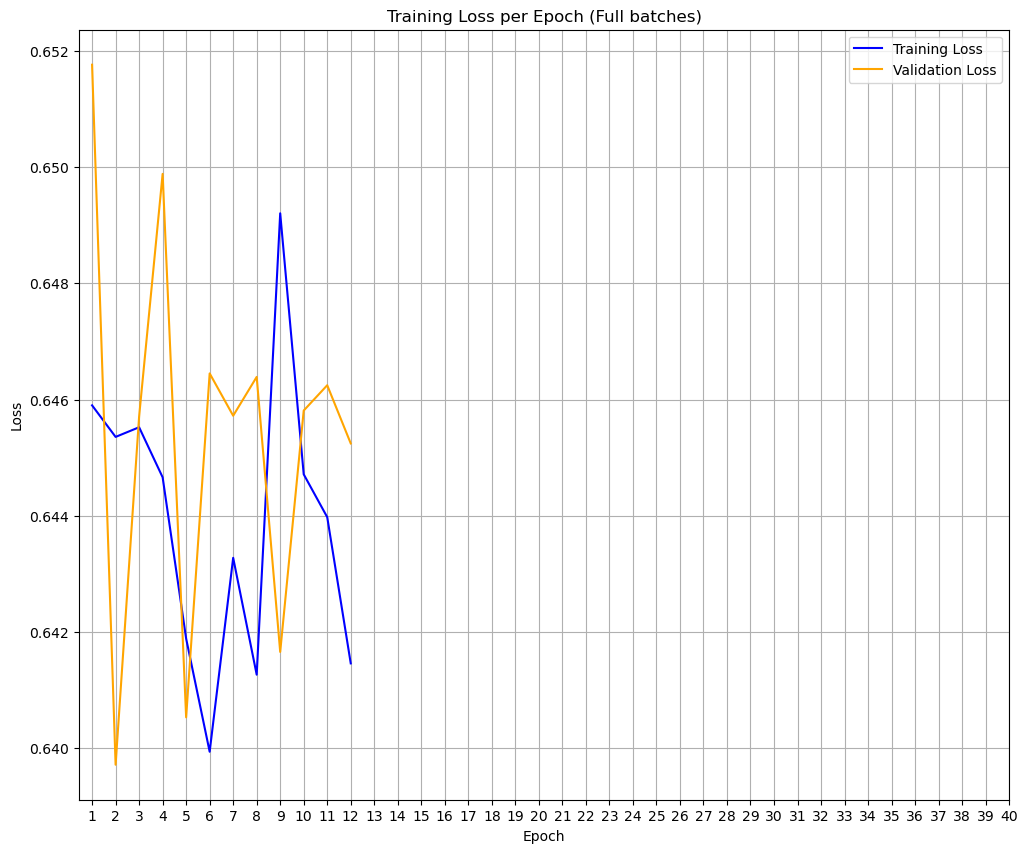

---- SEARCH OVER PARAMS: REAL AMP CIRC.: Num_qubits: 4 num_layers: 4 learning_rate: 0.1 ----


Results for mini_batch updates:
Best Validation Loss: 0.346
Best Params: [ 1.63051008  2.2969208   1.4804343   1.45506984  2.34622338  0.78056196
  1.62051801 -0.02445752  2.60979503  1.58760485  1.38817667  3.15334486
  1.00947961  1.44403008  1.94430829  1.6472934 ]

Results for full_batch updates:
Best Validation Loss: 0.640
Best Params: [1.11292329 1.65091142 1.51362711 0.55562713 1.2162807  3.02815783
 0.78169756 0.4200494  1.31489131 2.48316785 1.8283758  2.13977847
 0.5958308  1.9443056  1.01653528 2.62100968]

Results for single_datapoint updates:
Best Validation Loss: 0.635
Best Params: [ 1.5439019   2.86750838  2.47356101  1.56165205  0.31762765  0.42291896
 -0.37008331  2.37318323  1.96623992  2.37607537  0.1796892   3.20791049
  2.71683215  0.41296675  0.90313287  0.81398162]


In [23]:
num_qubits_3, num_layers_3, name_3, search_3 = search_for_optimal_params(num_qubits = 4, num_layers = 4, learning_rate = 0.1, realAMP = True)
iterate_params_retrieved(num_qubits_3, num_layers_3, name_3, search_3)
list_of_params_retrieved.append([num_qubits_3, num_layers_3, name_3, search_3])

Current search:
PARAMS (REAL AMP CIRC.): Qubits 4, Layers 5, Learning rate 0.1 


###################################################################
#             TESTING TRAINING (single datapoint update):         #
###################################################################
#### INITIALIZING TRAINING (single datapoint updates) #####
Epoch 1 Finished (Time used: 2.17 min)
Epoch stats:
 --- Training loss: 0.485
 --- Validation Loss: 0.538

Epoch 2 Finished (Time used: 2.17 min)
Epoch stats:
 --- Training loss: 0.527
 --- Validation Loss: 0.518

Epoch 3 Finished (Time used: 2.19 min)
Epoch stats:
 --- Training loss: 1.279
 --- Validation Loss: 1.256

Epoch 4 Finished (Time used: 2.18 min)
Epoch stats:
 --- Training loss: 1.379
 --- Validation Loss: 1.332

Epoch 5 Finished (Time used: 2.17 min)
Epoch stats:
 --- Training loss: 1.312
 --- Validation Loss: 1.281

Epoch 6 Finished (Time used: 2.17 min)
Epoch stats:
 --- Training loss: 1.311
 --- Validation Loss: 1.237

Epoch 7 Fini

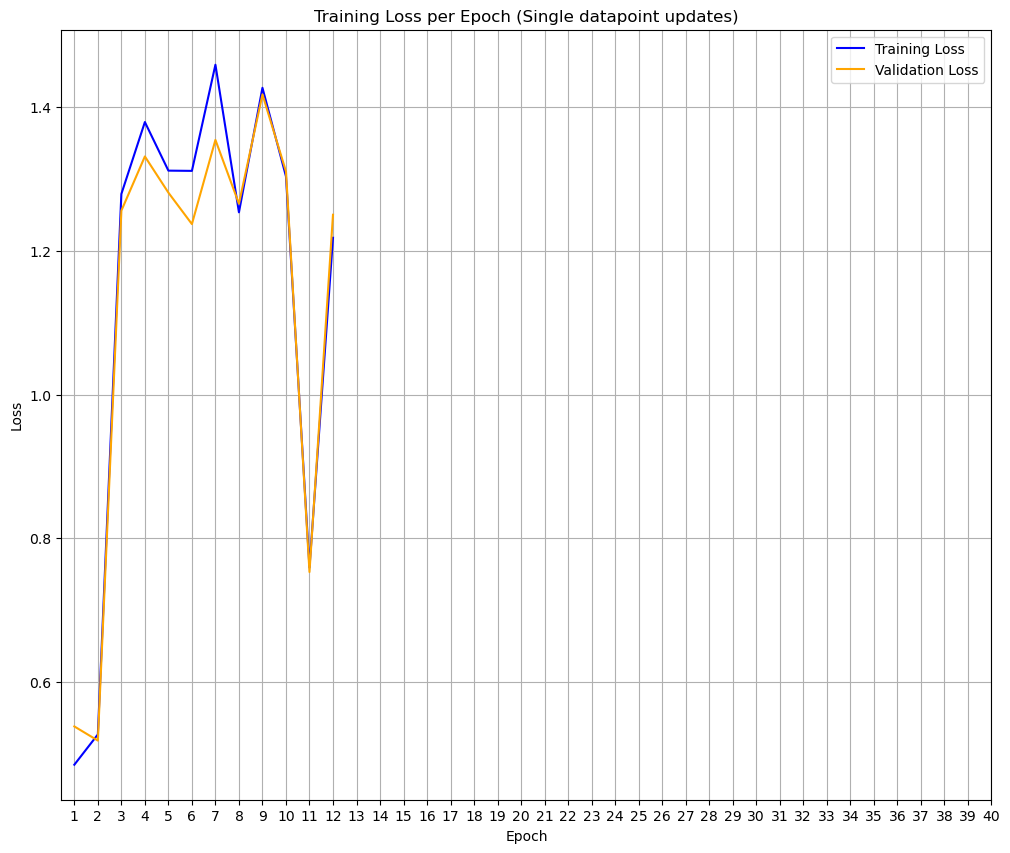

###################################################################
#               TESTING TRAINING (minibatch updates):             #
###################################################################
#### INITIALIZING TRAINING (mini batch updates) #####
Epoch 1 Finished (Time used: 2.18 min)
Epoch stats:
 --- Training loss: 0.723
 --- Validation Loss: 0.744

Epoch 2 Finished (Time used: 2.16 min)
Epoch stats:
 --- Training loss: 0.725
 --- Validation Loss: 0.745

Epoch 3 Finished (Time used: 2.17 min)
Epoch stats:
 --- Training loss: 0.735
 --- Validation Loss: 0.762

Epoch 4 Finished (Time used: 2.17 min)
Epoch stats:
 --- Training loss: 0.745
 --- Validation Loss: 0.768

Epoch 5 Finished (Time used: 2.16 min)
Epoch stats:
 --- Training loss: 0.772
 --- Validation Loss: 0.805

Epoch 6 Finished (Time used: 2.17 min)
Epoch stats:
 --- Training loss: 0.793
 --- Validation Loss: 0.812

Epoch 7 Finished (Time used: 2.16 min)
Epoch stats:
 --- Training loss: 0.806
 --- Validation Loss: 

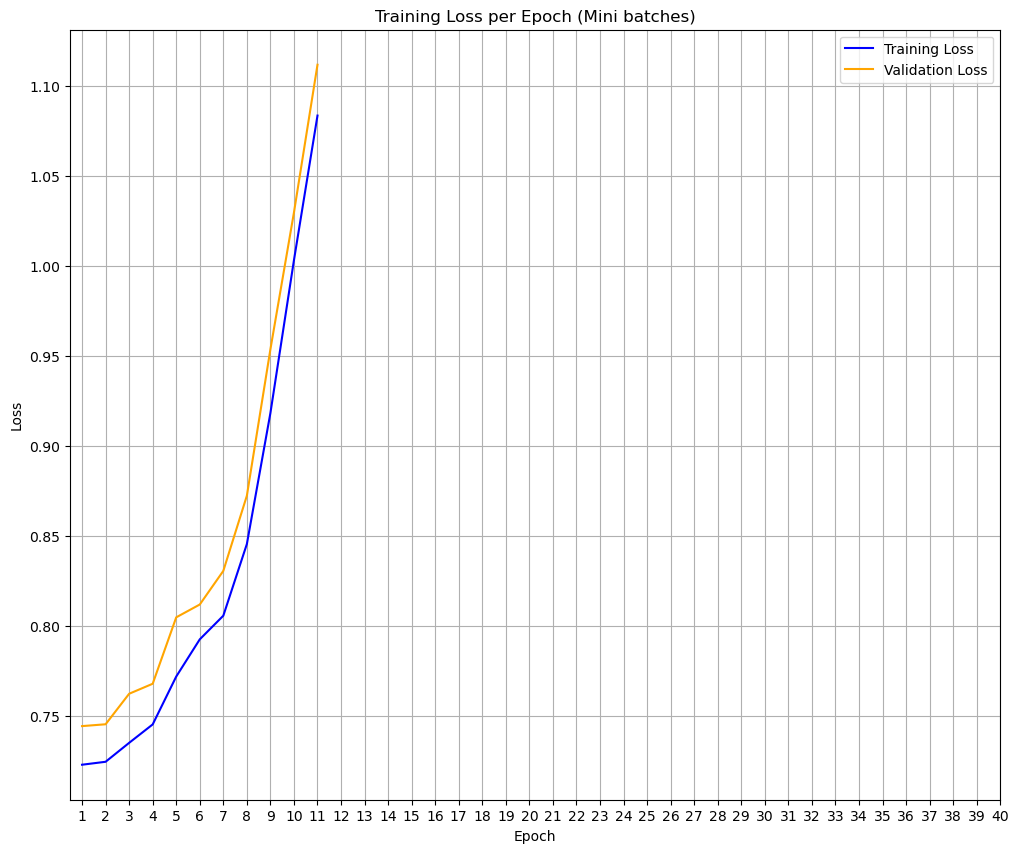

###################################################################
#               TESTING TRAINING (fullbatch updates):             #
###################################################################
#### INITIALIZING TRAINING (full batch updates) #####
Epoch 1 Finished (Time used: 2.17 min)
Epoch stats:
 --- Training loss: 0.584
 --- Validation Loss: 0.596

Epoch 2 Finished (Time used: 2.16 min)
Epoch stats:
 --- Training loss: 0.582
 --- Validation Loss: 0.594

Epoch 3 Finished (Time used: 2.16 min)
Epoch stats:
 --- Training loss: 0.581
 --- Validation Loss: 0.589

Epoch 4 Finished (Time used: 2.16 min)
Epoch stats:
 --- Training loss: 0.585
 --- Validation Loss: 0.588

Epoch 5 Finished (Time used: 2.16 min)
Epoch stats:
 --- Training loss: 0.579
 --- Validation Loss: 0.585

Epoch 6 Finished (Time used: 2.16 min)
Epoch stats:
 --- Training loss: 0.576
 --- Validation Loss: 0.595

Epoch 7 Finished (Time used: 2.17 min)
Epoch stats:
 --- Training loss: 0.585
 --- Validation Loss: 

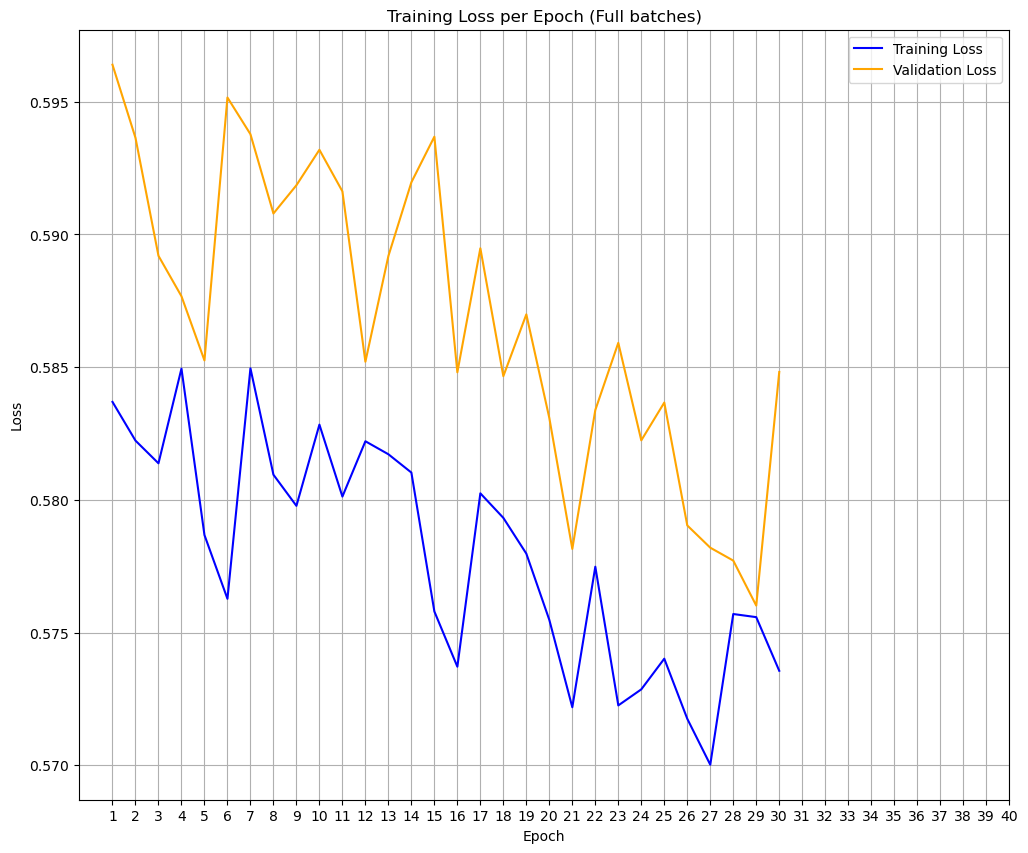

---- SEARCH OVER PARAMS: REAL AMP CIRC.: Num_qubits: 4 num_layers: 5 learning_rate: 0.1 ----


Results for mini_batch updates:
Best Validation Loss: 0.744
Best Params: [1.52704632 1.16990425 1.25748191 2.63395672 2.92153708 0.21143094
 0.64646973 2.09611124 1.13111554 0.81049247 0.94248622 1.01209225
 2.66619099 0.43641925 2.21163166 1.72972672 0.92729739 1.32711336
 0.81077757 1.92579689]

Results for full_batch updates:
Best Validation Loss: 0.576
Best Params: [0.30011418 2.23033803 1.40325846 2.88144389 2.30771975 0.53642472
 1.94523798 1.24607159 1.87453118 2.30322879 2.6510342  2.71604682
 0.77596114 0.03133374 2.36871099 0.47735415 0.97519006 0.03475691
 2.09716265 0.61527305]

Results for single_datapoint updates:
Best Validation Loss: 0.518
Best Params: [ 2.01886595  2.78455799  1.58753277  2.22608823  0.62898683  0.71679307
  0.29685698  3.07964471  2.34514868  2.33310766 -0.31567839  4.28464679
  1.71574503 -0.21006801  0.83321806  0.91962636  1.15752182  3.29678132
  1.41058

In [24]:
num_qubits_4, num_layers_4, name_4, search_4 = search_for_optimal_params(num_qubits = 4, num_layers = 5, learning_rate = 0.1, realAMP = True)
iterate_params_retrieved(num_qubits_4, num_layers_4, name_4, search_4)
list_of_params_retrieved.append([num_qubits_4, num_layers_4, name_4, search_4])

Current search:
PARAMS (REAL AMP CIRC.): Qubits 2, Layers 4, Learning rate 0.1 


###################################################################
#             TESTING TRAINING (single datapoint update):         #
###################################################################
#### INITIALIZING TRAINING (single datapoint updates) #####
Epoch 1 Finished (Time used: 0.87 min)
Epoch stats:
 --- Training loss: 0.663
 --- Validation Loss: 0.690

Epoch 2 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 0.972
 --- Validation Loss: 0.855

Epoch 3 Finished (Time used: 0.87 min)
Epoch stats:
 --- Training loss: 0.540
 --- Validation Loss: 0.570

Epoch 4 Finished (Time used: 0.87 min)
Epoch stats:
 --- Training loss: 0.764
 --- Validation Loss: 0.728

Epoch 5 Finished (Time used: 0.87 min)
Epoch stats:
 --- Training loss: 0.701
 --- Validation Loss: 0.756

Epoch 6 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 1.073
 --- Validation Loss: 1.148

Epoch 7 Fini

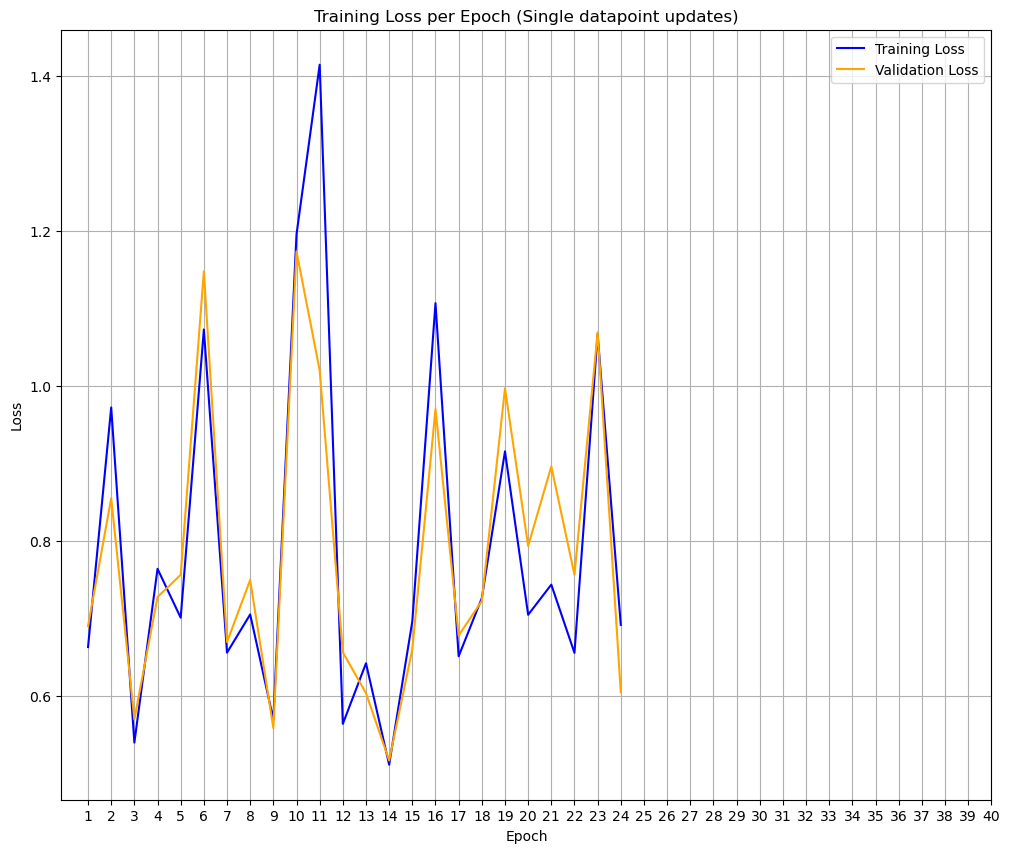

###################################################################
#               TESTING TRAINING (minibatch updates):             #
###################################################################
#### INITIALIZING TRAINING (mini batch updates) #####
Epoch 1 Finished (Time used: 0.87 min)
Epoch stats:
 --- Training loss: 0.622
 --- Validation Loss: 0.599

Epoch 2 Finished (Time used: 0.87 min)
Epoch stats:
 --- Training loss: 0.654
 --- Validation Loss: 0.619

Epoch 3 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 0.688
 --- Validation Loss: 0.661

Epoch 4 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 0.769
 --- Validation Loss: 0.724

Epoch 5 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 0.864
 --- Validation Loss: 0.824

Epoch 6 Finished (Time used: 0.87 min)
Epoch stats:
 --- Training loss: 1.003
 --- Validation Loss: 0.974

Epoch 7 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 1.060
 --- Validation Loss: 

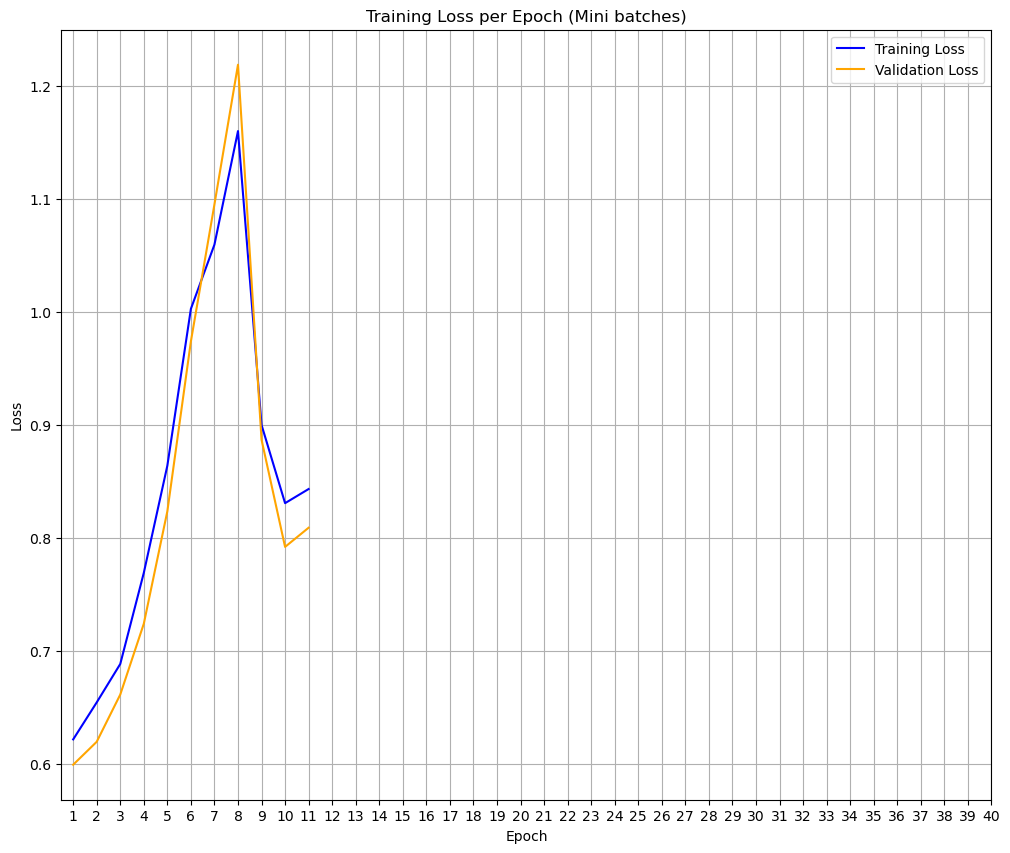

###################################################################
#               TESTING TRAINING (fullbatch updates):             #
###################################################################
#### INITIALIZING TRAINING (full batch updates) #####
Epoch 1 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 0.818
 --- Validation Loss: 0.739

Epoch 2 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 0.816
 --- Validation Loss: 0.738

Epoch 3 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 0.819
 --- Validation Loss: 0.741

Epoch 4 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 0.823
 --- Validation Loss: 0.742

Epoch 5 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 0.818
 --- Validation Loss: 0.740

Epoch 6 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 0.821
 --- Validation Loss: 0.742

Epoch 7 Finished (Time used: 0.88 min)
Epoch stats:
 --- Training loss: 0.822
 --- Validation Loss: 

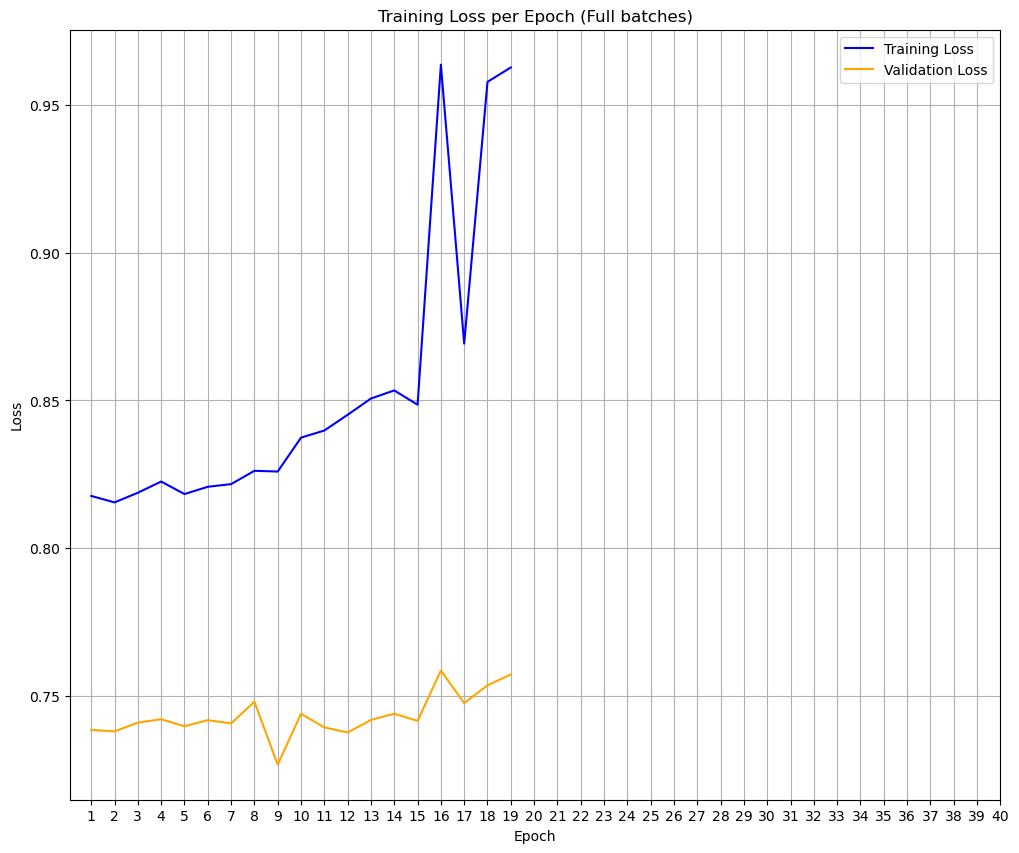

---- SEARCH OVER PARAMS: REAL AMP CIRC.: Num_qubits: 2 num_layers: 4 learning_rate: 0.1 ----


Results for mini_batch updates:
Best Validation Loss: 0.599
Best Params: [0.84967206 3.07182514 1.27385352 0.11713662 1.10000332 1.98299712
 2.15019272 1.71280272]

Results for full_batch updates:
Best Validation Loss: 0.727
Best Params: [2.84902214 1.93357528 1.09765524 2.59183871 1.17443511 0.13221951
 2.64630375 1.10981012]

Results for single_datapoint updates:
Best Validation Loss: 0.517
Best Params: [-4.8494845   3.90662155 29.13235765 -6.72863192 -0.17168897 10.63261726
  2.58637784 13.59277452]


In [27]:
num_qubits_5, num_layers_5, name_5, search_5 = search_for_optimal_params(num_qubits = 2, num_layers = 4, learning_rate = 0.1, realAMP = True)
iterate_params_retrieved(num_qubits_5, num_layers_5, name_5, search_5)
list_of_params_retrieved.append([num_qubits_5, num_layers_5, name_5, search_5])

Current search:
PARAMS (REAL AMP CIRC.): Qubits 2, Layers 5, Learning rate 0.1 


###################################################################
#             TESTING TRAINING (single datapoint update):         #
###################################################################
#### INITIALIZING TRAINING (single datapoint updates) #####
Epoch 1 Finished (Time used: 1.07 min)
Epoch stats:
 --- Training loss: 0.679
 --- Validation Loss: 0.697

Epoch 2 Finished (Time used: 1.07 min)
Epoch stats:
 --- Training loss: 0.662
 --- Validation Loss: 0.585

Epoch 3 Finished (Time used: 1.07 min)
Epoch stats:
 --- Training loss: 0.447
 --- Validation Loss: 0.434

Epoch 4 Finished (Time used: 1.07 min)
Epoch stats:
 --- Training loss: 0.749
 --- Validation Loss: 0.759

Epoch 5 Finished (Time used: 1.08 min)
Epoch stats:
 --- Training loss: 0.745
 --- Validation Loss: 0.705

Epoch 6 Finished (Time used: 1.07 min)
Epoch stats:
 --- Training loss: 2.295
 --- Validation Loss: 2.538

Epoch 7 Fini

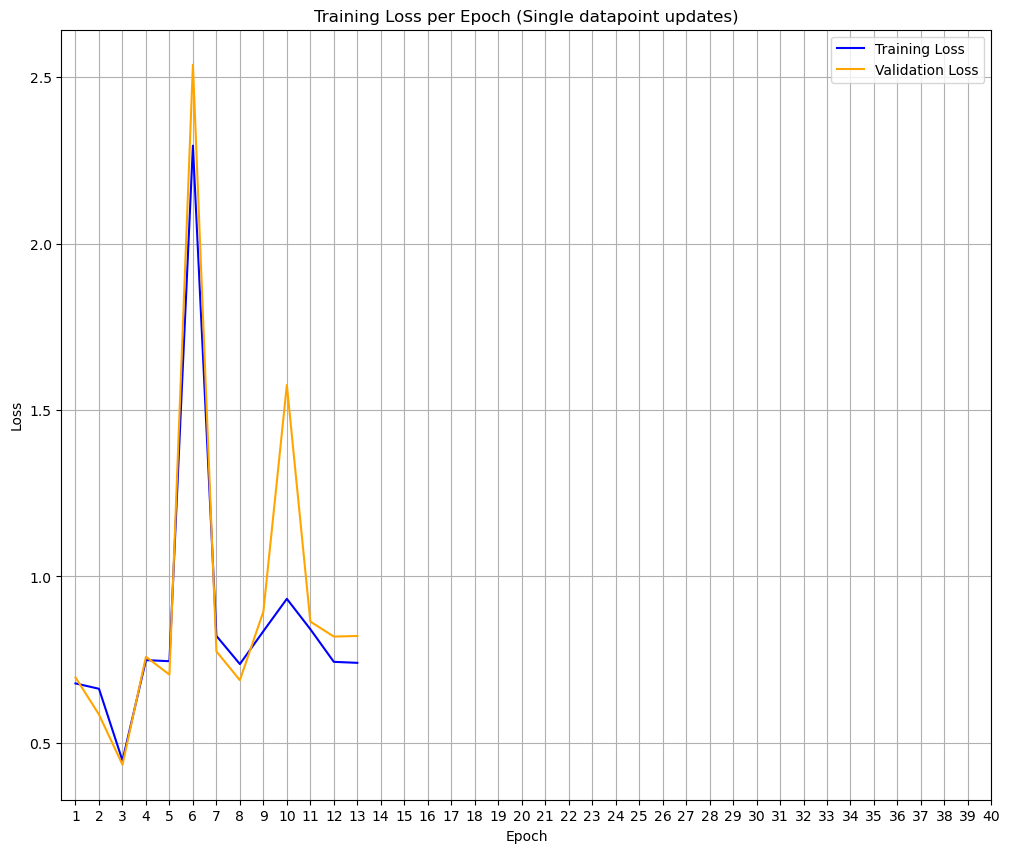

###################################################################
#               TESTING TRAINING (minibatch updates):             #
###################################################################
#### INITIALIZING TRAINING (mini batch updates) #####
Epoch 1 Finished (Time used: 1.07 min)
Epoch stats:
 --- Training loss: 0.734
 --- Validation Loss: 0.755

Epoch 2 Finished (Time used: 1.07 min)
Epoch stats:
 --- Training loss: 0.807
 --- Validation Loss: 0.823

Epoch 3 Finished (Time used: 1.07 min)
Epoch stats:
 --- Training loss: 0.740
 --- Validation Loss: 0.730

Epoch 4 Finished (Time used: 1.08 min)
Epoch stats:
 --- Training loss: 0.680
 --- Validation Loss: 0.664

Epoch 5 Finished (Time used: 1.07 min)
Epoch stats:
 --- Training loss: 0.663
 --- Validation Loss: 0.640

Epoch 6 Finished (Time used: 1.08 min)
Epoch stats:
 --- Training loss: 0.756
 --- Validation Loss: 0.738

Epoch 7 Finished (Time used: 1.08 min)
Epoch stats:
 --- Training loss: 0.664
 --- Validation Loss: 

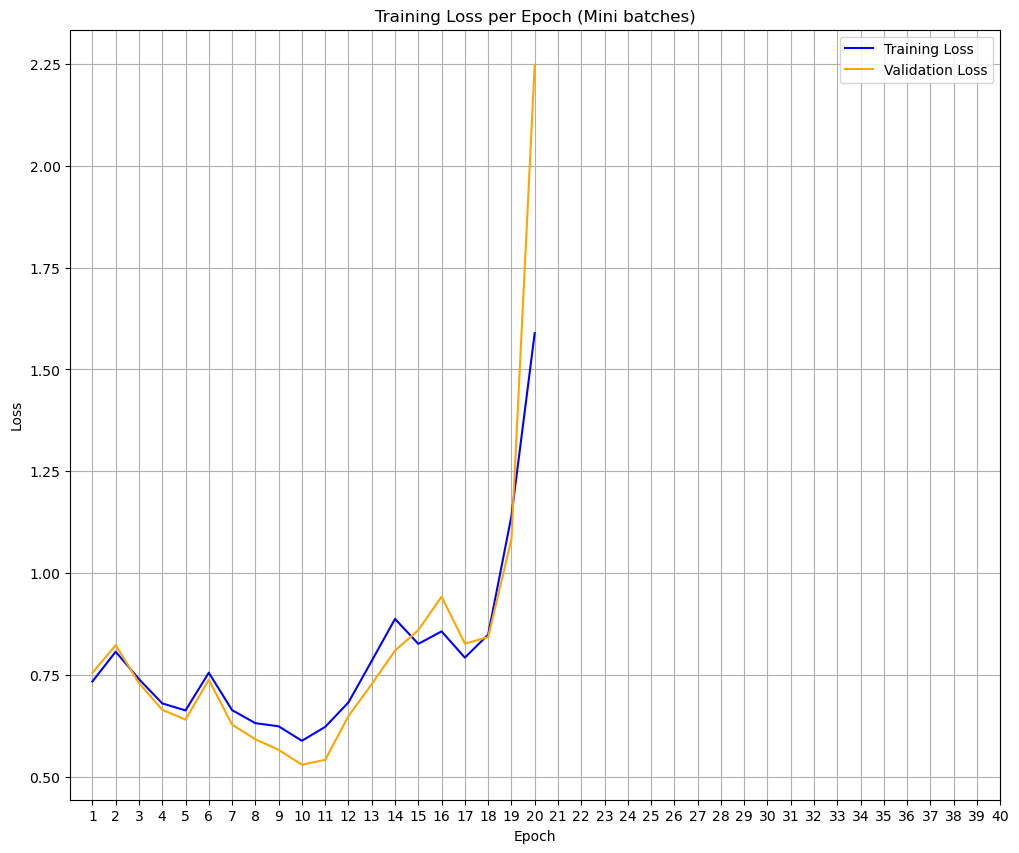

###################################################################
#               TESTING TRAINING (fullbatch updates):             #
###################################################################
#### INITIALIZING TRAINING (full batch updates) #####
Epoch 1 Finished (Time used: 1.08 min)
Epoch stats:
 --- Training loss: 0.779
 --- Validation Loss: 0.812

Epoch 2 Finished (Time used: 1.08 min)
Epoch stats:
 --- Training loss: 0.781
 --- Validation Loss: 0.803

Epoch 3 Finished (Time used: 1.08 min)
Epoch stats:
 --- Training loss: 0.785
 --- Validation Loss: 0.805

Epoch 4 Finished (Time used: 1.07 min)
Epoch stats:
 --- Training loss: 0.792
 --- Validation Loss: 0.816

Epoch 5 Finished (Time used: 1.07 min)
Epoch stats:
 --- Training loss: 0.786
 --- Validation Loss: 0.816

Epoch 6 Finished (Time used: 1.08 min)
Epoch stats:
 --- Training loss: 0.793
 --- Validation Loss: 0.828

Epoch 7 Finished (Time used: 1.07 min)
Epoch stats:
 --- Training loss: 0.792
 --- Validation Loss: 

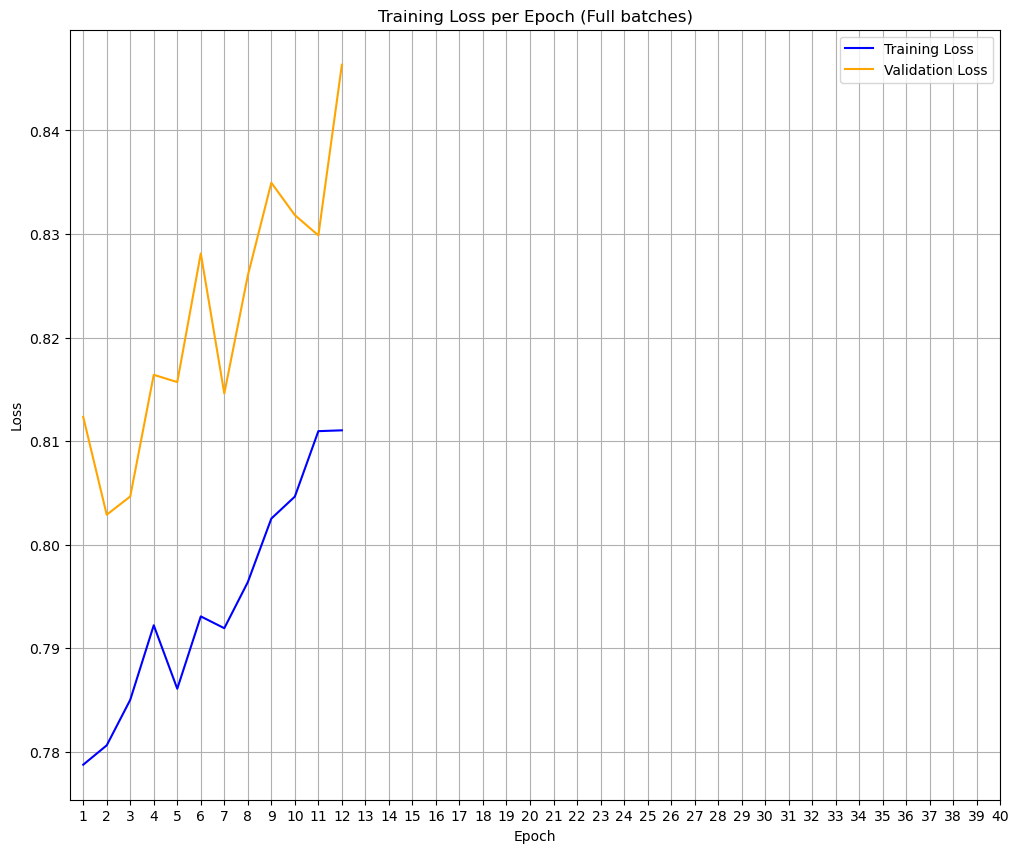

---- SEARCH OVER PARAMS: REAL AMP CIRC.: Num_qubits: 2 num_layers: 5 learning_rate: 0.1 ----


Results for mini_batch updates:
Best Validation Loss: 0.530
Best Params: [ 3.06002368  0.48043509 -0.07078904  2.12345221  1.84491117  3.02745469
  0.96028796  1.30284829  1.94347812  2.07596883]

Results for full_batch updates:
Best Validation Loss: 0.803
Best Params: [0.10919089 2.81153227 2.70011898 1.44707492 1.22841287 0.85851697
 1.48762789 0.14115372 2.67648166 0.11121156]

Results for single_datapoint updates:
Best Validation Loss: 0.434
Best Params: [ 6.17630171  2.21010084 -7.81687343  0.4692302  -5.4213848  -9.54594837
 -0.24807393  2.68802846 -7.49261192  6.28551495]


In [28]:
num_qubits_6, num_layers_6, name_6, search_6 = search_for_optimal_params(num_qubits = 2, num_layers = 5, learning_rate = 0.1, realAMP = True)
iterate_params_retrieved(num_qubits_6, num_layers_6, name_6, search_6)
list_of_params_retrieved.append([num_qubits_6, num_layers_6, name_6, search_6])

---

&nbsp;

### Model evaluation

After a large amount of searching we can at last send `list_of_params_retrieved` to our `test_best_performing_model` function. This function will choose the model which achieved the lowest validation loss as our chosen model. Furthermore, this chosen model will be tested on the test data:

#############################
#   Best Performing Model   #
#############################
 --- Params ---
REAL AMP CIRC.: Num_qubits: 4 num_layers: 4 learning_rate: 0.1

 --- Variational params ---
 θ_1 = 1.63, θ_2 = 2.30, θ_3 = 1.48, θ_4 = 1.46, θ_5 = 2.35,
 θ_6 = 0.78, θ_7 = 1.62, θ_8 = -0.02, θ_9 = 2.61, θ_10 = 1.59,
 θ_11 = 1.39, θ_12 = 3.15, θ_13 = 1.01, θ_14 = 1.44, θ_15 = 1.94,
 θ_16 = 1.65.


 --- Accuracy on test data ---
Accuracy: 0.652


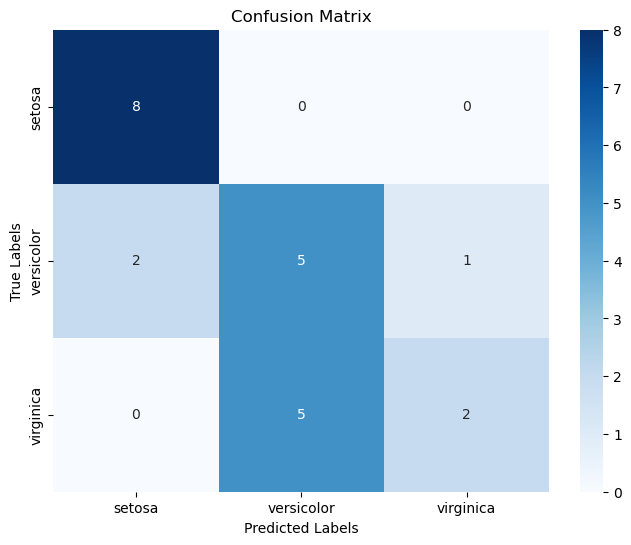

In [29]:
test_best_performing_model(list_of_params_retrieved)